# Cuboid cutout

We will need to cut out a cube from the data, let's try to implement this here.

In [1]:
import platform
import os
import glob
import pandas
import numpy
import imageio
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn
import skimage.filters
import dask
import dask_image.imread
from dask.distributed import Client
from numcodecs import Blosc
import tqdm
from tqdm import notebook
import math

In [2]:
# Set dask temporary folder
# Do this before creating a client: https://stackoverflow.com/a/62804525/323100
if 'Linux' in platform.system():
    tmp = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
elif 'Darwin' in platform.system():
    import tempfile
    tmp = tempfile.gettempdir()
else:
    if 'anaklin' in platform.node():
        tmp = os.path.join('F:\\')
    else:
        tmp = os.path.join('D:\\')
dask.config.set({'temporary_directory': os.path.join(tmp, 'tmp')})

In [3]:
# Start dask client and tell where we can see what it does
client = Client()
print('You can seee what DASK is doing at "http://localhost:%s/status"' % client.scheduler_info()['services']['dashboard'])

You can seee what DASK is doing at "http://localhost:8787/status"


In [4]:
# Ignore warnings in the notebook
#import warnings
#warnings.filterwarnings("ignore")

In [5]:
# Set up figure defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w and with 'nearest' interpolation
plt.rcParams['figure.figsize'] = (16, 9)  # Size up figures a bit
plt.rcParams['figure.dpi'] = 200  # Increase dpi

In [6]:
# Setup scale bar defaults
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = 'white'

In [7]:
# Display all plots identically
lines = 3
# And then do something like
# plt.subplot(lines, int(numpy.ceil(len(Data) / float(lines))), c + 1)

In [8]:
def get_git_hash():
    """
    Get the current git hash from the repository.
    Based on http://stackoverflow.com/a/949391/323100 and
    http://stackoverflow.com/a/18283905/323100
    """
    from subprocess import Popen, PIPE
    import os
    gitprocess = Popen(['git', '--git-dir', os.path.join(os.getcwd(), '.git'),
                        'rev-parse', '--short', '--verify', 'HEAD'],
                       stdout=PIPE)
    (output, _) = gitprocess.communicate()
    return output.strip().decode("utf-8")

In [9]:
# What are we working with?
the_current_git_hash = get_git_hash()
print('We are working with version %s of the analyis notebook.'
      % the_current_git_hash)

We are working with version f2aaa63 of the analyis notebook.


In [10]:
# Generate the output folder
# Including the git hash, so we (potentially) have different versions of all the images we generate
OutputDir = os.path.join('Output', the_current_git_hash)
os.makedirs(OutputDir, exist_ok=True)

In [11]:
# Different locations if running either on Linux or Windows
if 'anaklin' in platform.node():
    FastSSD = True
else:
    FastSSD = False
# to speed things up significantly
if 'Linux' in platform.system():
    if FastSSD:
        BasePath = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
    else:
        BasePath = os.path.join(os.sep, 'home', 'habi', '1272')
elif 'Darwin' in platform.system():
    BasePath = os.path.join('/Volumes/2TBSSD/')
else:
    if FastSSD:
        BasePath = os.path.join('F:\\')
    else:
        if 'anaklin' in platform.node():
            BasePath = os.path.join('S:\\')
        else:
            BasePath = os.path.join('D:\\', 'Results')
Root = os.path.join(BasePath, 'Hearts Melly')
print('We are loading all the data from %s' % Root)

We are loading all the data from F:\Hearts Melly


In [12]:
def get_pixelsize(logfile):
    """Get the pixel size from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Image Pixel' in line and 'Scaled' not in line:
                pixelsize = float(line.split('=')[1])
    return(pixelsize)

In [13]:
# The three cardinal directions
directions = ['Axial', 'Sagittal', 'Coronal']

In [14]:
# Make us a dataframe for saving all that we need
Data = pandas.DataFrame()

In [15]:
# Get *all* log files
Data['LogFile'] = [f for f in sorted(glob.glob(os.path.join(Root, '**', '*.log'), recursive=True))]

In [16]:
# Get all folders
Data['Folder'] = [os.path.dirname(f) for f in Data['LogFile']]

In [17]:
# Get rid of all non-rec logfiles
for c, row in Data.iterrows():
    if 'rec' not in row.Folder:
        Data.drop([c], inplace=True)
    elif 'ctan.log' in row.LogFile:
        Data.drop([c], inplace=True)
    elif 'rectmp.log' in row.LogFile:
        Data.drop([c], inplace=True)
# Reset dataframe to something that we would get if we only would have loaded the 'rec' files
Data = Data.reset_index(drop=True)

In [18]:
# Drop all folders we don't need
for c, row in Data.iterrows():
    if 'Rat' not in row.Folder:
        Data.drop([c], inplace=True)
    elif 'Rat4' in row.Folder:
        Data.drop([c], inplace=True)
    elif 'Rat5' in row.Folder:
        Data.drop([c], inplace=True)
    elif 'Test' in row.Folder:
        Data.drop([c], inplace=True)
# Reset dataframe to something that we would get if we only would have loaded the 'rec' files
Data = Data.reset_index(drop=True)

In [19]:
Data.tail()

,LogFile,Folder
50,F:\Hearts Melly\Rat83\overview\rec\Rat83_rec.log,F:\Hearts Melly\Rat83\overview\rec
51,F:\Hearts Melly\Rat83b\overview\rec\Rat83_rec.log,F:\Hearts Melly\Rat83b\overview\rec
52,F:\Hearts Melly\Rat84\cu_10um\rec\Rat84_rec.log,F:\Hearts Melly\Rat84\cu_10um\rec
53,F:\Hearts Melly\Rat84\cu_lowres\rec\Rat84_rec.log,F:\Hearts Melly\Rat84\cu_lowres\rec
54,F:\Hearts Melly\Rat84\overview\rec\Rat84_rec.log,F:\Hearts Melly\Rat84\overview\rec


In [20]:
# Generate us some meaningful colums
Data['Animal'] = [l[len(Root)+1:].split(os.sep)[0] for l in Data['LogFile']]
Data['Scan'] = ['_'.join(l[len(Root)+1:].split(os.sep)[1:-1]) for l in Data['LogFile']]

In [21]:
print('We habe %s scans of %s rats to work with' % (len(Data), len(Data.Animal.unique())))

We habe 55 scans of 20 rats to work with


In [22]:
# Read in animals list from Ludovic
AnimalTable = pandas.read_excel('Animals.xlsx',
                                engine='openpyxl',
                                header=None,
                                names=['Animal', 'Gender', '', 'Experiment', 'Timepoint'])

In [23]:
# Merge in data from animals table
for c, rowdata in Data.iterrows():
    for d, rowanimals in AnimalTable.iterrows():
        if str(rowanimals.Animal) in rowdata.Animal:
            Data.at[c, 'Experiment'] = rowanimals.Experiment
            Data.at[c, 'Timepoint'] = rowanimals.Timepoint
            Data.at[c, 'Gender'] = rowanimals.Gender

In [24]:
# Now that we merged the data we can rename the column to a more reusable name
Data.columns = Data.columns.str.replace('Animal', 'Sample')

In [25]:
# Exclusion from Tims visual inspection
# R63
# R65
# R66
# R70
#exclude = [63, 65, 66, 70]

In [26]:
# Exclusion from Tims visual inspection for 2214 scans
# R67: "verstrahlt"
# R70: No tachosil
#exclude = [63, 65, 66, 70]

In [27]:
# Drop samples which should be excluded
# Based on https://stackoverflow.com/a/13851602
#for c,row in Data.iterrows():
#    for ex in exclude:
#        if str(ex) in row.Sample:
#            Data.drop(c, inplace=True)
#Data.reset_index(drop=True, inplace=True)

In [28]:
# # "Filter" to subset that we want
# for c,row in Data.iterrows():
#     if 'cu_10um' not in row.Scan:
#         Data.drop(c, inplace=True)
# Data.reset_index(drop=True, inplace=True)

In [29]:
# Tim delineated both the patch and myocard region
# We thus need to duplicate the dataframe for loading them correctly
Data = pandas.concat([Data] *2, ignore_index=True)
# First sort by animal, then by scan so the VOI colum filling works as intended
Data.sort_values(['Sample', 'Scan'], inplace=True)
# Fill actual VOI column with alternating values
Data['VOI'] = ['myocard', 'patch'] * (len(Data)//2)

In [30]:
Data.head(n=8)

,LogFile,Folder,Sample,Scan,Experiment,Timepoint,Gender,VOI
0,F:\Hearts Melly\Rat60\cu_10um\rec\Rat60_rec.log,F:\Hearts Melly\Rat60\cu_10um\rec,Rat60,cu_10um_rec,V+P,7.0,F,myocard
55,F:\Hearts Melly\Rat60\cu_10um\rec\Rat60_rec.log,F:\Hearts Melly\Rat60\cu_10um\rec,Rat60,cu_10um_rec,V+P,7.0,F,patch
1,F:\Hearts Melly\Rat60\overview\rec\Rat60_rec.log,F:\Hearts Melly\Rat60\overview\rec,Rat60,overview_rec,V+P,7.0,F,myocard
56,F:\Hearts Melly\Rat60\overview\rec\Rat60_rec.log,F:\Hearts Melly\Rat60\overview\rec,Rat60,overview_rec,V+P,7.0,F,patch
2,F:\Hearts Melly\Rat60\overview\rec_tweak\Rat60...,F:\Hearts Melly\Rat60\overview\rec_tweak,Rat60,overview_rec_tweak,V+P,7.0,F,myocard
57,F:\Hearts Melly\Rat60\overview\rec_tweak\Rat60...,F:\Hearts Melly\Rat60\overview\rec_tweak,Rat60,overview_rec_tweak,V+P,7.0,F,patch
3,F:\Hearts Melly\Rat61\cu_10um\rec\Rat61_rec.log,F:\Hearts Melly\Rat61\cu_10um\rec,Rat61,cu_10um_rec,V+P,7.0,F,myocard
58,F:\Hearts Melly\Rat61\cu_10um\rec\Rat61_rec.log,F:\Hearts Melly\Rat61\cu_10um\rec,Rat61,cu_10um_rec,V+P,7.0,F,patch


In [31]:
Data.tail(n=8)

,LogFile,Folder,Sample,Scan,Experiment,Timepoint,Gender,VOI
51,F:\Hearts Melly\Rat83b\overview\rec\Rat83_rec.log,F:\Hearts Melly\Rat83b\overview\rec,Rat83b,overview_rec,V,28.0,M,myocard
106,F:\Hearts Melly\Rat83b\overview\rec\Rat83_rec.log,F:\Hearts Melly\Rat83b\overview\rec,Rat83b,overview_rec,V,28.0,M,patch
52,F:\Hearts Melly\Rat84\cu_10um\rec\Rat84_rec.log,F:\Hearts Melly\Rat84\cu_10um\rec,Rat84,cu_10um_rec,V,28.0,M,myocard
107,F:\Hearts Melly\Rat84\cu_10um\rec\Rat84_rec.log,F:\Hearts Melly\Rat84\cu_10um\rec,Rat84,cu_10um_rec,V,28.0,M,patch
53,F:\Hearts Melly\Rat84\cu_lowres\rec\Rat84_rec.log,F:\Hearts Melly\Rat84\cu_lowres\rec,Rat84,cu_lowres_rec,V,28.0,M,myocard
108,F:\Hearts Melly\Rat84\cu_lowres\rec\Rat84_rec.log,F:\Hearts Melly\Rat84\cu_lowres\rec,Rat84,cu_lowres_rec,V,28.0,M,patch
54,F:\Hearts Melly\Rat84\overview\rec\Rat84_rec.log,F:\Hearts Melly\Rat84\overview\rec,Rat84,overview_rec,V,28.0,M,myocard
109,F:\Hearts Melly\Rat84\overview\rec\Rat84_rec.log,F:\Hearts Melly\Rat84\overview\rec,Rat84,overview_rec,V,28.0,M,patch


In [32]:
# Generate folder name
Data['VOIFolder'] = [os.path.join(os.path.dirname(f),
                                  'voi_' + v) for f, v in zip(Data['Folder'], Data['VOI'])]
# Load VOI images
Data['VOIFiles'] = [sorted(glob.glob(os.path.join(f, '*.png'))) for f in Data['VOIFolder']]
Data['Number of VOI slices'] = [len(vs) for vs in Data['VOIFiles']]

In [33]:
# Take a look at each VOI folder
# And drop those that are empty
for c, row in Data.iterrows():
    if not len(row['VOIFiles']):
        Data.drop(c, inplace=True)
Data.reset_index(drop=True, inplace=True)

In [34]:
print('We habe %s folders of %s samples to look into' % (len(Data), len(Data.Sample.unique())))

We habe 32 folders of 16 samples to look into


In [35]:
Data

,LogFile,Folder,Sample,Scan,Experiment,Timepoint,Gender,VOI,VOIFolder,VOIFiles,Number of VOI slices
0,F:\Hearts Melly\Rat60\cu_10um\rec\Rat60_rec.log,F:\Hearts Melly\Rat60\cu_10um\rec,Rat60,cu_10um_rec,V+P,7.0,F,myocard,F:\Hearts Melly\Rat60\cu_10um\voi_myocard,[F:\Hearts Melly\Rat60\cu_10um\voi_myocard\rat...,635
1,F:\Hearts Melly\Rat60\cu_10um\rec\Rat60_rec.log,F:\Hearts Melly\Rat60\cu_10um\rec,Rat60,cu_10um_rec,V+P,7.0,F,patch,F:\Hearts Melly\Rat60\cu_10um\voi_patch,[F:\Hearts Melly\Rat60\cu_10um\voi_patch\rat60...,635
2,F:\Hearts Melly\Rat61\cu_10um\rec\Rat61_rec.log,F:\Hearts Melly\Rat61\cu_10um\rec,Rat61,cu_10um_rec,V+P,7.0,F,myocard,F:\Hearts Melly\Rat61\cu_10um\voi_myocard,[F:\Hearts Melly\Rat61\cu_10um\voi_myocard\rat...,651
3,F:\Hearts Melly\Rat61\cu_10um\rec\Rat61_rec.log,F:\Hearts Melly\Rat61\cu_10um\rec,Rat61,cu_10um_rec,V+P,7.0,F,patch,F:\Hearts Melly\Rat61\cu_10um\voi_patch,[F:\Hearts Melly\Rat61\cu_10um\voi_patch\rat61...,651
4,F:\Hearts Melly\Rat62\cu_10um\rec\Rat62_rec.log,F:\Hearts Melly\Rat62\cu_10um\rec,Rat62,cu_10um_rec,F,7.0,F,myocard,F:\Hearts Melly\Rat62\cu_10um\voi_myocard,[F:\Hearts Melly\Rat62\cu_10um\voi_myocard\rat...,748
5,F:\Hearts Melly\Rat62\cu_10um\rec\Rat62_rec.log,F:\Hearts Melly\Rat62\cu_10um\rec,Rat62,cu_10um_rec,F,7.0,F,patch,F:\Hearts Melly\Rat62\cu_10um\voi_patch,[F:\Hearts Melly\Rat62\cu_10um\voi_patch\rat62...,748
6,F:\Hearts Melly\Rat63\2214_7.5um_Al1mm\rec\Rat...,F:\Hearts Melly\Rat63\2214_7.5um_Al1mm\rec,Rat63,2214_7.5um_Al1mm_rec,F,7.0,F,myocard,F:\Hearts Melly\Rat63\2214_7.5um_Al1mm\voi_myo...,[F:\Hearts Melly\Rat63\2214_7.5um_Al1mm\voi_my...,1045
7,F:\Hearts Melly\Rat63\2214_7.5um_Al1mm\rec\Rat...,F:\Hearts Melly\Rat63\2214_7.5um_Al1mm\rec,Rat63,2214_7.5um_Al1mm_rec,F,7.0,F,patch,F:\Hearts Melly\Rat63\2214_7.5um_Al1mm\voi_patch,[F:\Hearts Melly\Rat63\2214_7.5um_Al1mm\voi_pa...,1045
8,F:\Hearts Melly\Rat64\cu_10um\rec\Rat64_rec.log,F:\Hearts Melly\Rat64\cu_10um\rec,Rat64,cu_10um_rec,tachosil only,7.0,M,myocard,F:\Hearts Melly\Rat64\cu_10um\voi_myocard,[F:\Hearts Melly\Rat64\cu_10um\voi_myocard\rat...,737
9,F:\Hearts Melly\Rat64\cu_10um\rec\Rat64_rec.log,F:\Hearts Melly\Rat64\cu_10um\rec,Rat64,cu_10um_rec,tachosil only,7.0,M,patch,F:\Hearts Melly\Rat64\cu_10um\voi_patch,[F:\Hearts Melly\Rat64\cu_10um\voi_patch\rat64...,737


In [36]:
# Get voxelsize from logfiles
Data['Voxelsize'] = [get_pixelsize(log) for log in Data['LogFile']]

In [37]:
# Convert all VOI slices into a rechunked DASK array on disk for faster access
# Partially based on http://stackoverflow.com/a/39195332/323100
# and on /LungMetastasis/HighResolutionScanAnalysis.ipynb
Data['OutputNameVOI'] = [os.path.join(os.path.dirname(f),
                                      '%s_%s_voi_%s.zarr' % (sample,
                                                             scan,
                                                             voi)) for f, sample, scan, voi in zip(Data.Folder,
                                                                                                   Data.Sample,
                                                                                                   Data.Scan,
                                                                                                   Data.VOI)]
for c, row in notebook.tqdm(Data.iterrows(), desc='Reading VOIs', total=len(Data)):
    if not os.path.exists(row['OutputNameVOI']):
        print('%2s/%s: Reading %s VOI slices from %s and saving to %s' % (c + 1,
                                                                          len(Data),
                                                                          row['Number of VOI slices'],
                                                                          row['VOIFolder'][len(Root)+1:],
                                                                          row['OutputNameVOI'][len(Root)+1:]))
        VOI = dask_image.imread.imread(os.path.join(row['VOIFolder'], '*.png'))
        # Rechunking (to 'auto' size) is slow, but we only need to do it once and
        # further reads of the data are much faster.
        VOI.rechunk('auto').to_zarr(row['OutputNameVOI'],
                                    compressor=Blosc(cname='zstd',
                                                     clevel=9,
                                                     shuffle=Blosc.BITSHUFFLE))

Reading VOIs:   0%|          | 0/32 [00:00<?, ?it/s]

In [38]:
# Load the reconstructions a zarr arrays
Patches = [dask.array.from_zarr(file) for file in Data[Data.VOI == 'patch']['OutputNameVOI']]
Myocards = [dask.array.from_zarr(file) for file in Data[Data.VOI == 'myocard']['OutputNameVOI']]

In [39]:
# Generate some dummy data, clear it and append it to dataframe for the MSP VOIs
_ = pandas.DataFrame()
_ = Data[Data.VOI == 'myocard']
_['VOI'].replace(['myocard'], 'myocard_sans_patch', inplace=True)
_.loc[:, ('VOIFolder', 'VOIFiles', 'OutputNameVOI', 'Number of VOI slices')] = ''
UpDatedData = pandas.concat((Data, _))
Data = UpDatedData.copy(deep=True)
Data.sort_values(['Sample', 'Scan'], inplace=True)
Data.reset_index(drop=True, inplace=True)

C:\Users\haberthu\Miniconda3\lib\site-packages\pandas\core\generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
C:\Users\haberthu\Miniconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [40]:
Data

,LogFile,Folder,Sample,Scan,Experiment,Timepoint,Gender,VOI,VOIFolder,VOIFiles,Number of VOI slices,Voxelsize,OutputNameVOI
0,F:\Hearts Melly\Rat60\cu_10um\rec\Rat60_rec.log,F:\Hearts Melly\Rat60\cu_10um\rec,Rat60,cu_10um_rec,V+P,7.0,F,myocard,F:\Hearts Melly\Rat60\cu_10um\voi_myocard,[F:\Hearts Melly\Rat60\cu_10um\voi_myocard\rat...,635,10.000036,F:\Hearts Melly\Rat60\cu_10um\Rat60_cu_10um_re...
1,F:\Hearts Melly\Rat60\cu_10um\rec\Rat60_rec.log,F:\Hearts Melly\Rat60\cu_10um\rec,Rat60,cu_10um_rec,V+P,7.0,F,patch,F:\Hearts Melly\Rat60\cu_10um\voi_patch,[F:\Hearts Melly\Rat60\cu_10um\voi_patch\rat60...,635,10.000036,F:\Hearts Melly\Rat60\cu_10um\Rat60_cu_10um_re...
2,F:\Hearts Melly\Rat60\cu_10um\rec\Rat60_rec.log,F:\Hearts Melly\Rat60\cu_10um\rec,Rat60,cu_10um_rec,V+P,7.0,F,myocard_sans_patch,,,,10.000036,
3,F:\Hearts Melly\Rat61\cu_10um\rec\Rat61_rec.log,F:\Hearts Melly\Rat61\cu_10um\rec,Rat61,cu_10um_rec,V+P,7.0,F,myocard,F:\Hearts Melly\Rat61\cu_10um\voi_myocard,[F:\Hearts Melly\Rat61\cu_10um\voi_myocard\rat...,651,10.000036,F:\Hearts Melly\Rat61\cu_10um\Rat61_cu_10um_re...
4,F:\Hearts Melly\Rat61\cu_10um\rec\Rat61_rec.log,F:\Hearts Melly\Rat61\cu_10um\rec,Rat61,cu_10um_rec,V+P,7.0,F,patch,F:\Hearts Melly\Rat61\cu_10um\voi_patch,[F:\Hearts Melly\Rat61\cu_10um\voi_patch\rat61...,651,10.000036,F:\Hearts Melly\Rat61\cu_10um\Rat61_cu_10um_re...
5,F:\Hearts Melly\Rat61\cu_10um\rec\Rat61_rec.log,F:\Hearts Melly\Rat61\cu_10um\rec,Rat61,cu_10um_rec,V+P,7.0,F,myocard_sans_patch,,,,10.000036,
6,F:\Hearts Melly\Rat62\cu_10um\rec\Rat62_rec.log,F:\Hearts Melly\Rat62\cu_10um\rec,Rat62,cu_10um_rec,F,7.0,F,myocard,F:\Hearts Melly\Rat62\cu_10um\voi_myocard,[F:\Hearts Melly\Rat62\cu_10um\voi_myocard\rat...,748,10.000036,F:\Hearts Melly\Rat62\cu_10um\Rat62_cu_10um_re...
7,F:\Hearts Melly\Rat62\cu_10um\rec\Rat62_rec.log,F:\Hearts Melly\Rat62\cu_10um\rec,Rat62,cu_10um_rec,F,7.0,F,patch,F:\Hearts Melly\Rat62\cu_10um\voi_patch,[F:\Hearts Melly\Rat62\cu_10um\voi_patch\rat62...,748,10.000036,F:\Hearts Melly\Rat62\cu_10um\Rat62_cu_10um_re...
8,F:\Hearts Melly\Rat62\cu_10um\rec\Rat62_rec.log,F:\Hearts Melly\Rat62\cu_10um\rec,Rat62,cu_10um_rec,F,7.0,F,myocard_sans_patch,,,,10.000036,
9,F:\Hearts Melly\Rat63\2214_7.5um_Al1mm\rec\Rat...,F:\Hearts Melly\Rat63\2214_7.5um_Al1mm\rec,Rat63,2214_7.5um_Al1mm_rec,F,7.0,F,myocard,F:\Hearts Melly\Rat63\2214_7.5um_Al1mm\voi_myo...,[F:\Hearts Melly\Rat63\2214_7.5um_Al1mm\voi_my...,1045,7.500482,F:\Hearts Melly\Rat63\2214_7.5um_Al1mm\Rat63_2...


In [41]:
Data[ Data['VOI'] == 'myocard_sans_patch']

,LogFile,Folder,Sample,Scan,Experiment,Timepoint,Gender,VOI,VOIFolder,VOIFiles,Number of VOI slices,Voxelsize,OutputNameVOI
2,F:\Hearts Melly\Rat60\cu_10um\rec\Rat60_rec.log,F:\Hearts Melly\Rat60\cu_10um\rec,Rat60,cu_10um_rec,V+P,7.0,F,myocard_sans_patch,,,,10.000036,
5,F:\Hearts Melly\Rat61\cu_10um\rec\Rat61_rec.log,F:\Hearts Melly\Rat61\cu_10um\rec,Rat61,cu_10um_rec,V+P,7.0,F,myocard_sans_patch,,,,10.000036,
8,F:\Hearts Melly\Rat62\cu_10um\rec\Rat62_rec.log,F:\Hearts Melly\Rat62\cu_10um\rec,Rat62,cu_10um_rec,F,7.0,F,myocard_sans_patch,,,,10.000036,
11,F:\Hearts Melly\Rat63\2214_7.5um_Al1mm\rec\Rat...,F:\Hearts Melly\Rat63\2214_7.5um_Al1mm\rec,Rat63,2214_7.5um_Al1mm_rec,F,7.0,F,myocard_sans_patch,,,,7.500482,
14,F:\Hearts Melly\Rat64\cu_10um\rec\Rat64_rec.log,F:\Hearts Melly\Rat64\cu_10um\rec,Rat64,cu_10um_rec,tachosil only,7.0,M,myocard_sans_patch,,,,10.000036,
17,F:\Hearts Melly\Rat65\cu_10um\rec\Rat65_rec.log,F:\Hearts Melly\Rat65\cu_10um\rec,Rat65,cu_10um_rec,tachosil only,7.0,M,myocard_sans_patch,,,,10.000036,
20,F:\Hearts Melly\Rat66\2214_7.5um_Al1mm\rec\Rat...,F:\Hearts Melly\Rat66\2214_7.5um_Al1mm\rec,Rat66,2214_7.5um_Al1mm_rec,V+P,28.0,M,myocard_sans_patch,,,,7.500482,
23,F:\Hearts Melly\Rat67\cu_10um\rec\Rat67_rec.log,F:\Hearts Melly\Rat67\cu_10um\rec,Rat67,cu_10um_rec,F,28.0,M,myocard_sans_patch,,,,10.000036,
26,F:\Hearts Melly\Rat68\cu_10um\rec\Rat68_rec.log,F:\Hearts Melly\Rat68\cu_10um\rec,Rat68,cu_10um_rec,V+P,28.0,M,myocard_sans_patch,,,,10.000036,
29,F:\Hearts Melly\Rat69\cu_10um\rec\Rat69_rec.log,F:\Hearts Melly\Rat69\cu_10um\rec,Rat69,cu_10um_rec,F,28.0,M,myocard_sans_patch,,,,10.000036,


In [42]:
# Save 'myocard sans patch' data
Data['OutputNameVOI'] = [os.path.join(os.path.dirname(f),
                                      '%s_%s_voi_%s.zarr' % (sample,
                                                             scan,
                                                             voi)) for f, sample, scan, voi in zip(Data.Folder,
                                                                                                   Data.Sample,
                                                                                                   Data.Scan,
                                                                                                   Data.VOI)]
# https://stackoverflow.com/a/55437530/323100
for c, row in notebook.tqdm(enumerate(Data[Data['VOI'] == 'myocard_sans_patch'].iterrows()),
                            desc='Calculating MSP VOIs',
                            total=len(Data[Data['VOI'] == 'myocard_sans_patch'])):
    if not os.path.exists(row[1]['OutputNameVOI']):
        print('%2s/%s: Calculating MSP VOI and saving to %s' % (c + 1,
                                                                len(Data[ Data['VOI'] == 'myocard_sans_patch']),
                                                                row[1]['OutputNameVOI'][len(Root)+1:]))
        MSP = dask.array.subtract(Myocards[c], Patches[c])
        MSP.rechunk('auto').to_zarr(row[1]['OutputNameVOI'],
                                    compressor=Blosc(cname='zstd',
                                                     clevel=9,
                                                     shuffle=Blosc.BITSHUFFLE))

Calculating MSP VOIs:   0%|          | 0/16 [00:00<?, ?it/s]

In [43]:
# load MSPs from disk
MSP = [dask.array.from_zarr(file) for file in Data[Data.VOI == 'myocard_sans_patch']['OutputNameVOI']]

In [ ]:
# Display 'myocard sans patch' slice
whichslice = 444
vmax=66
for c, sample in enumerate(Data.Sample.unique()):
    plt.subplot(1,3,1)
    plt.imshow(Patches[c][whichslice], vmax=vmax)
    plt.imshow(Patches[c][whichslice]!=0, cmap='viridis_r', alpha=0.309)
    plt.title('%s: Patch' % sample)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(Myocards[c][whichslice], vmax=vmax)
    plt.imshow(Myocards[c][whichslice]!=0, cmap='viridis_r', alpha=0.309)
    plt.title('%s: Myocard' % sample)
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(MSP[c][whichslice], vmax=vmax)
    plt.imshow(MSP[c][whichslice]!=0, cmap='viridis_r', alpha=0.309)
    plt.title('%s: M-P' % sample)   
    plt.axis('off')
    plt.show()

In [44]:
# Load *all* VOIs
VOIs = [dask.array.from_zarr(file) for file in Data['OutputNameVOI']]

In [298]:
# How big are the datasets?
Data['Size'] = [v.shape for v in VOIs]

In [299]:
# Put middle image into dataframe for easier handling
Data['Image'] = [v[v.shape[0]//2].compute() for v in VOIs]

In [48]:
def get_roi(img, verbose=False):
    # Extrapolate ROI by thresholding to the data and filling small holes
    thresholded_img = skimage.filters.gaussian(img, sigma=0.5) > 0
    filled_holes_img = skimage.morphology.remove_small_holes(thresholded_img, 1)
    removed_small_stuff_img = skimage.morphology.remove_small_objects(filled_holes_img > 0, 1000)
    if verbose:
        plt.subplot(141)
        plt.imshow(img)
        plt.title('Original image')
        plt.axis('off')
        plt.subplot(142)
        plt.imshow(thresholded_img)
        plt.title('Thresholded to > 0')
        plt.axis('off')
        plt.subplot(143)
        plt.imshow(filled_holes_img)
        plt.title('Filled small holes')
        plt.axis('off')
        plt.subplot(144)
        plt.imshow(img)
        plt.imshow(numpy.ma.masked_equal(removed_small_stuff_img, 0),
                   alpha=0.618,
                   cmap='viridis_r')
        plt.title('Extrapolated ROI')
        plt.axis('off')
        plt.show()
    return(removed_small_stuff_img)

In [49]:
# Do it in a loop, so we can use verbose if we want
Data['ROI'] = ''
for c, row in notebook.tqdm(Data.iterrows(),
                            desc='Extrapolate ROI',
                            total=len(Data)):
    Data.at[c, 'ROI'] = get_roi(row.Image, verbose=False)

Extrapolate ROI:   0%|          | 0/48 [00:00<?, ?it/s]

In [50]:
def get_properties(roi, verbose=False):
    # Label filled image
    labeled_img = skimage.measure.label(roi)
    # Extract regionprops of image and put data into pandas
    # https://stackoverflow.com/a/66632023/323100
    props = skimage.measure.regionprops_table(labeled_img,
                                              properties=('label',
                                                          'centroid',
                                                          'area',
                                                          'perimeter',
                                                          'orientation'))
    table = pandas.DataFrame(props)
    table_sorted = table.sort_values(by='area', ascending=False)
    # return only the region with the biggest area
    properties = table_sorted.iloc[:1].reset_index()
    if verbose:
        plt.imshow(roi, alpha=0.5)
        plt.title('Original')
        plt.axis('off')
        plt.imshow(numpy.ma.masked_equal(labeled_img, 0), cmap='viridis', alpha=0.5)
        plt.title('Labelled')
        plt.axis('off')
        plt.show()
    return(properties)

In [51]:
# Do it in a loop, so we can use verbose if we want
Data['Properties'] = ''
for c, row in notebook.tqdm(Data.iterrows(),
                            desc='Calculate properties',
                            total=len(Data)):
    Data.at[c, 'Properties'] = get_properties(row['ROI'], verbose=False)

Calculate properties:   0%|          | 0/48 [00:00<?, ?it/s]

In [52]:
def get_largest_region(segmentation, verbose=False):
    # Get out biggest item from https://stackoverflow.com/a/55110923/323100
    labels = skimage.measure.label(segmentation)
    assert( labels.max() != 0 ) # assume at least 1 CC
    largestCC = labels == numpy.argmax(numpy.bincount(labels.flat)[1:])+1
    if verbose:
        plt.subplot(121)
        plt.imshow(segmentation)
        plt.subplot(122)
        plt.imshow(largestCC)
        plt.suptitle('Largest connected component')
        plt.show()
    return largestCC

In [53]:
def get_contour(filled_img, verbose=False):
    # Contouring from https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_regionprops.html
    largest_region = get_largest_region(filled_img, verbose=False)
    contour = skimage.measure.find_contours(largest_region)
    # Even though we look only at the largest region, we still might get out more than one contour
    # Let's thus sort the list and just continue with the longest one 
    (contour).sort(key=len)
    cy, cx = contour[-1].T
    if verbose:
        plt.imshow(filled_img)
        plt.plot(cx, cy, lw=1, c='r')
        plt.axis('off')
        plt.show()
    return(cx, cy)

In [54]:
# Do it in a loop, so we can use verbose if we want
Data['Contour'] = ''
for c, row in notebook.tqdm(Data.iterrows(),
                            desc='Extracting contour',
                            total=len(Data)):
    Data.at[c, 'Contour'] = get_contour(row['ROI'], verbose=False)

Extracting contour:   0%|          | 0/48 [00:00<?, ?it/s]

In [55]:
def get_centroid(img, verbose=False):
    props = get_properties(img)
    # Drawing from https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_regionprops.html
    y0, x0 = props['centroid-0'], props['centroid-1']
    if verbose:
        plt.imshow(img)
        plt.scatter(props['centroid-1'], props['centroid-0'], marker=None, color='r')
        plt.axis('off')
        plt.show()
    return((x0,y0))

In [56]:
# Do it in a loop, so we can use verbose if we want
Data['Centroid'] = ''
for c, row in notebook.tqdm(Data.iterrows(),
                            desc='Calculating centroid',
                            total=len(Data)):
    Data.at[c, 'Centroid'] = get_centroid(row['ROI'], verbose=False)

Calculating centroid:   0%|          | 0/48 [00:00<?, ?it/s]

In [57]:
def draw_orientation(img, x0, x1, x2, y0, y1, y2, self=False):
    if self:
        plt.imshow(img)
    plt.plot((x0, x1), (y0, y1), '-r', linewidth=1)
    plt.plot((x0, x2), (y0, y2), '-r', linewidth=1)
    if self:
        plt.axis('off')
        plt.show()
    return()

In [58]:
def get_orientation(img, voxelsize, length=5000, verbose=False):
    props = get_properties(img)
    whichlengthdowewant = length
    reallength= whichlengthdowewant / voxelsize # um
    # Drawing from https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_regionprops.htm
    x0, y0 = get_centroid(img)
    x1 = x0 + math.cos(props['orientation']) * reallength
    y1 = y0 - math.sin(props['orientation']) * reallength
    x2 = x0 - math.sin(props['orientation']) * reallength
    y2 = y0 - math.cos(props['orientation']) * reallength
    if verbose:
        plt.imshow(img)
        plt.scatter(props['centroid-1'], props['centroid-0'], marker=None, color='r')
        draw_orientation(img, x0, x1, x2, y0, y1, y2)
        plt.gca().add_artist(ScaleBar(voxelsize, 'um'))
        plt.title('Image with %s um long orientation bars' % length)
        plt.axis('off')
        plt.show()
    return(x0,x1,x2,y0,y1,y2)

In [59]:
# Do it in a loop, so we can use verbose if we want
Data['Orientation'] = ''
for c, row in notebook.tqdm(Data.iterrows(),
                            desc='Extracting contour',
                            total=len(Data)):
    Data.at[c, 'Orientation'] = get_orientation(row['ROI'], voxelsize=row['Voxelsize'], verbose=False)

Extracting contour:   0%|          | 0/48 [00:00<?, ?it/s]

In [60]:
lines = 6

In [ ]:
# Draw everything
for c,row in notebook.tqdm(Data.iterrows(), total=len(Data)):
    plt.subplot(lines, int(numpy.ceil(len(Data) / float(lines))), c + 1)
    plt.imshow(row.Image)
    plt.plot(row.Contour[0], row.Contour[1], lw=1, c='r')
    plt.scatter(row.Centroid[0], row.Centroid[1], marker=None, color='w')
    draw_orientation(row.ROI,
                     row.Orientation[0], row.Orientation[1],
                     row.Orientation[2], row.Orientation[3],
                     row.Orientation[4], row.Orientation[5])
    plt.gca().add_artist(ScaleBar(row.Voxelsize, 'um'))
    plt.axis('off')
    plt.title('(%s) %s: %s' % (c, row.Sample, row.VOI))
    # plt.tight_layout()
plt.show()

In [61]:
def midpoint(x1, y1, x2, y2):
    '''calculate the middle between two points'''
    midpoint = (x1 + x2)/2, (y1 + y2)/2
    return(midpoint)

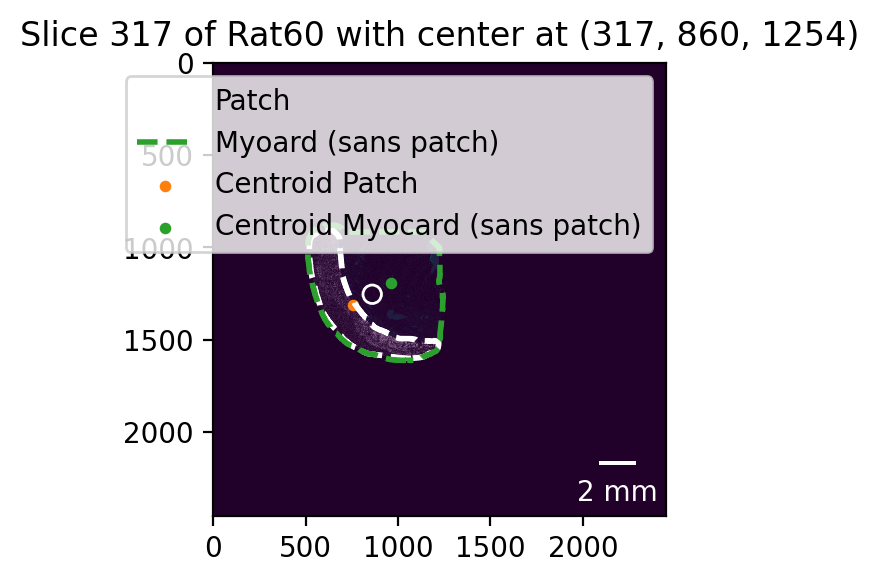

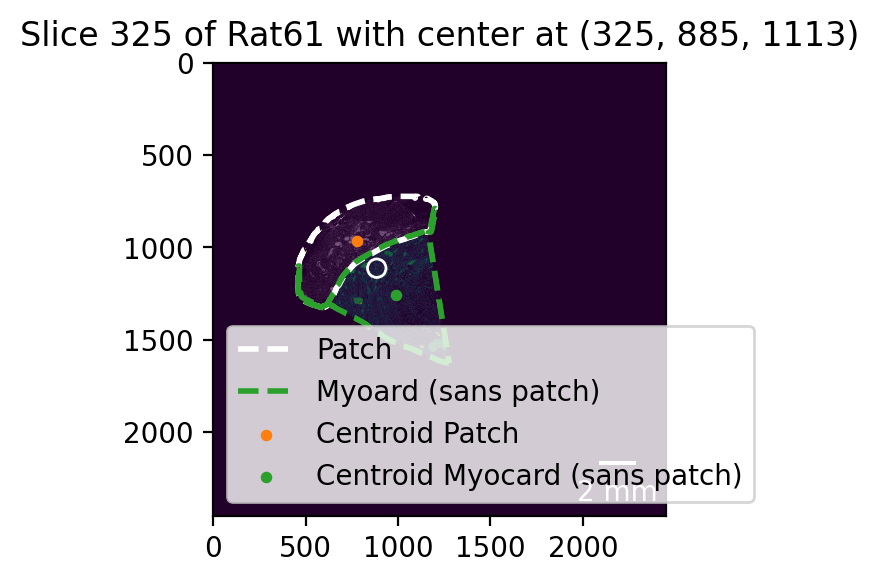

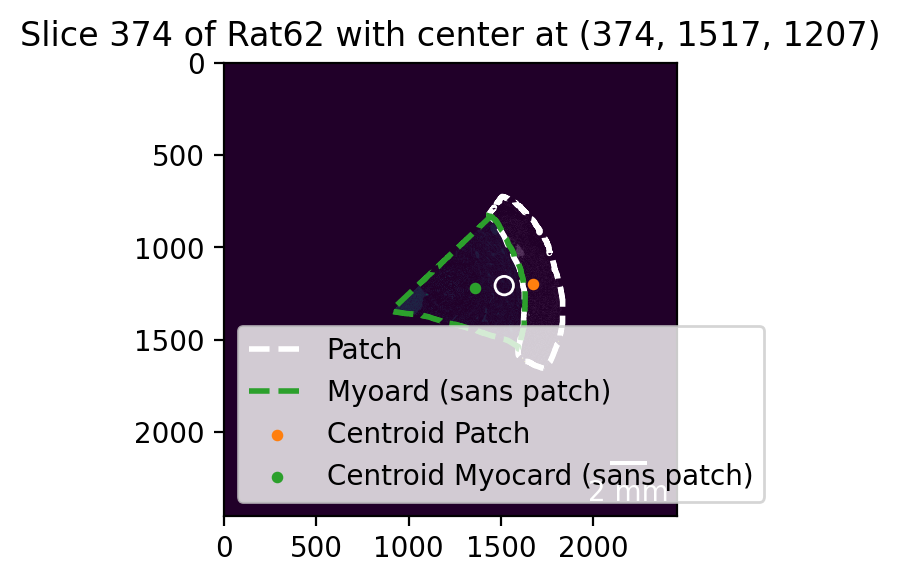

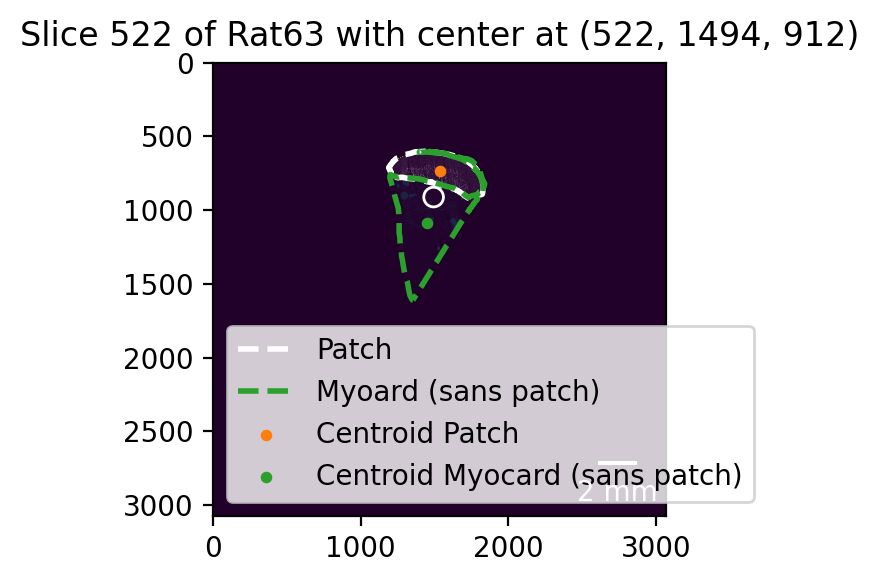

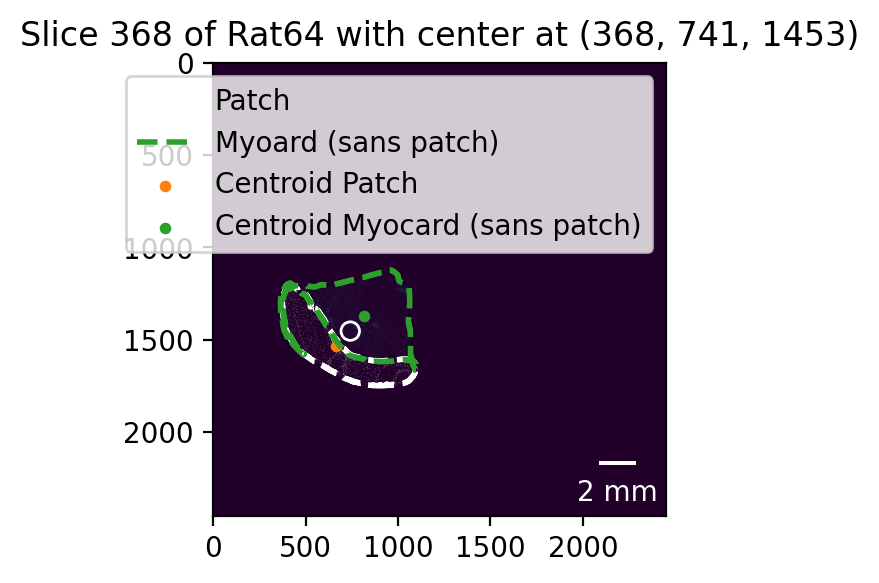

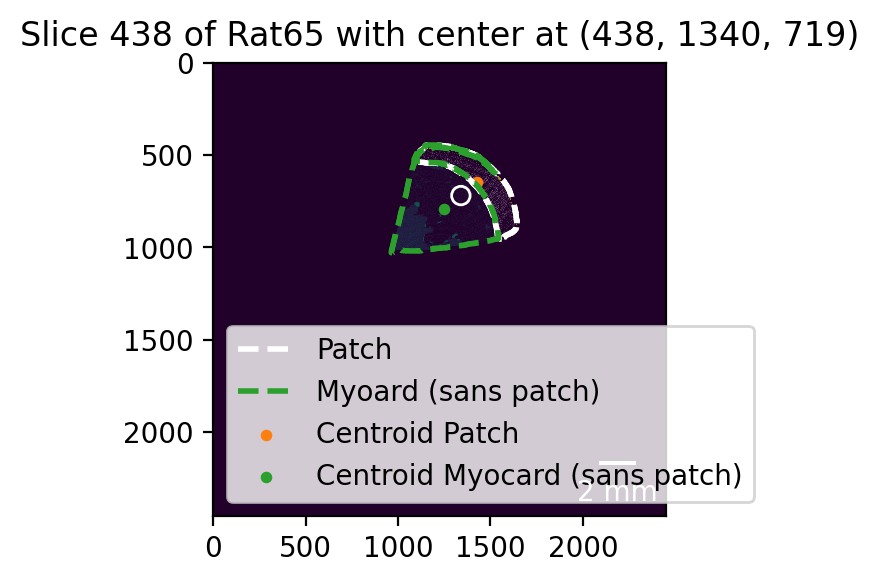

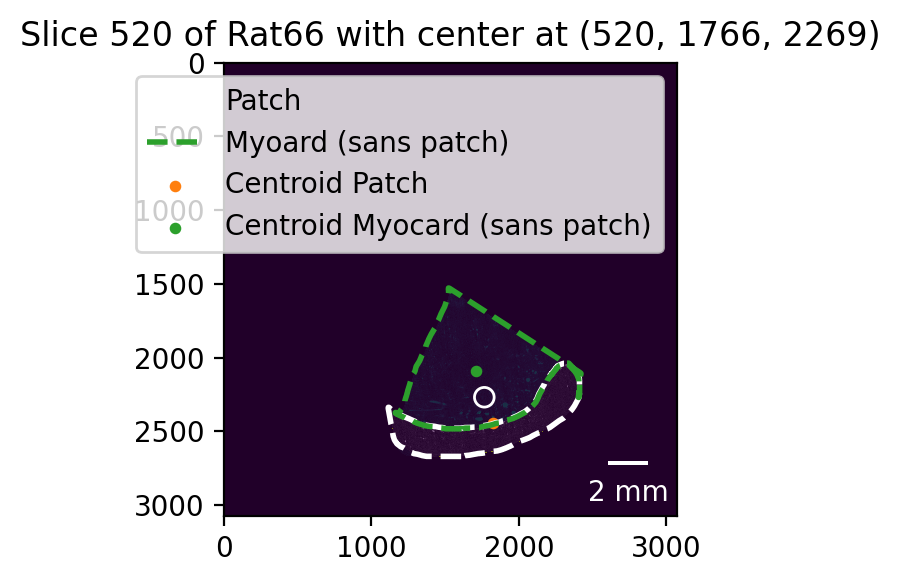

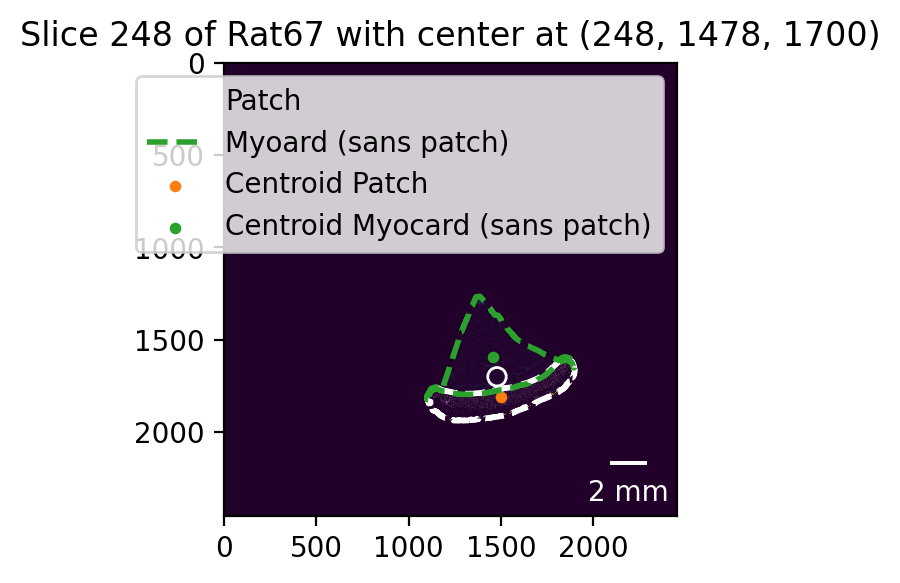

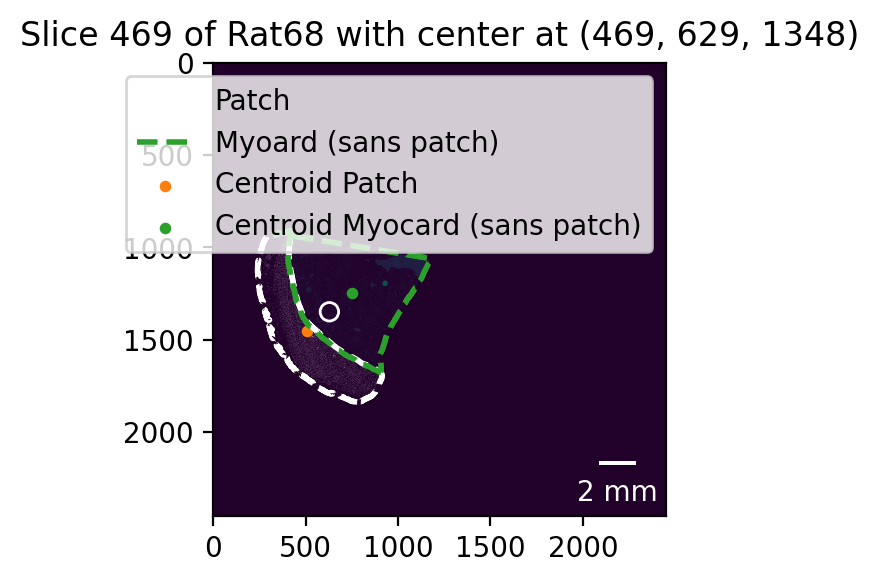

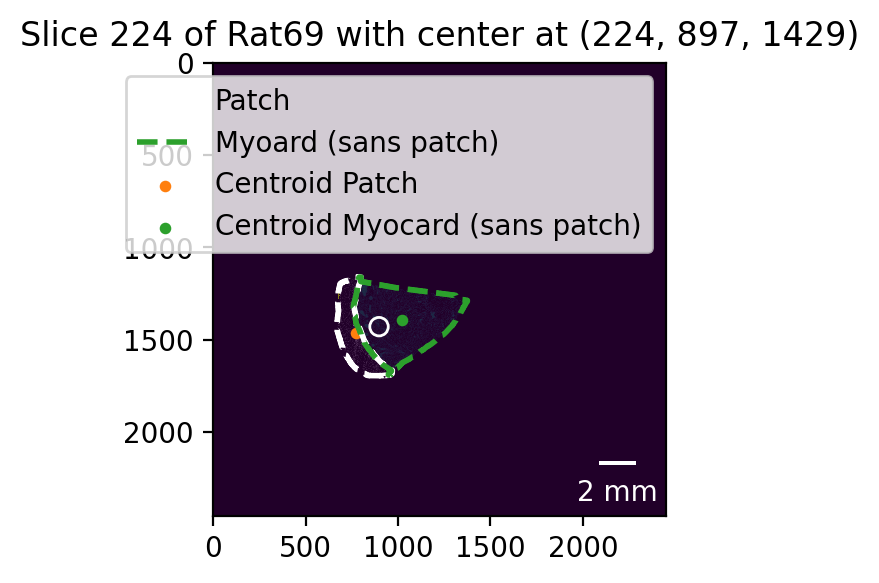

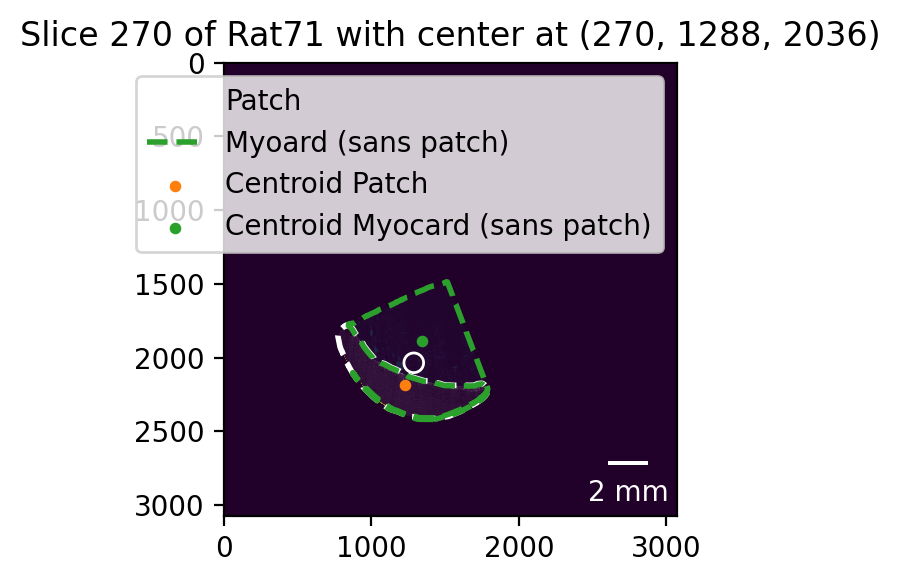

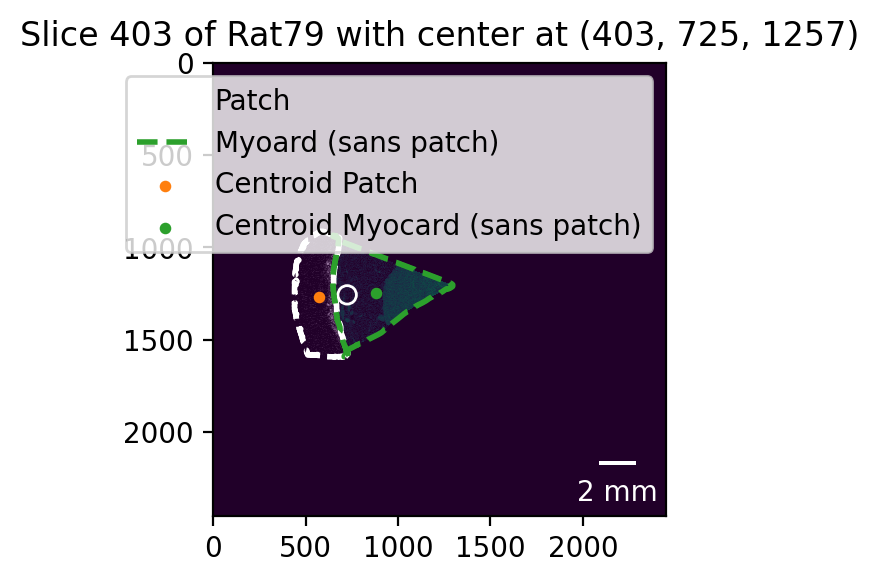

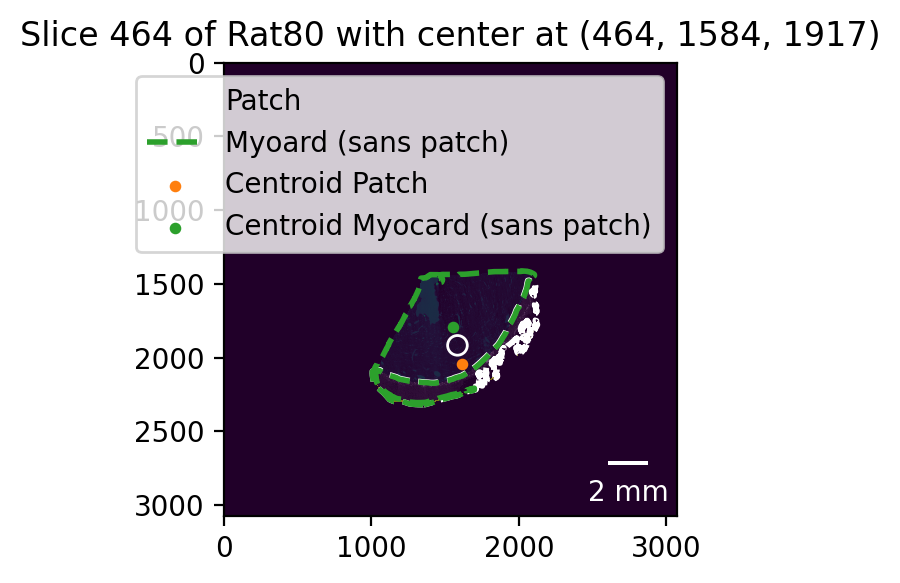

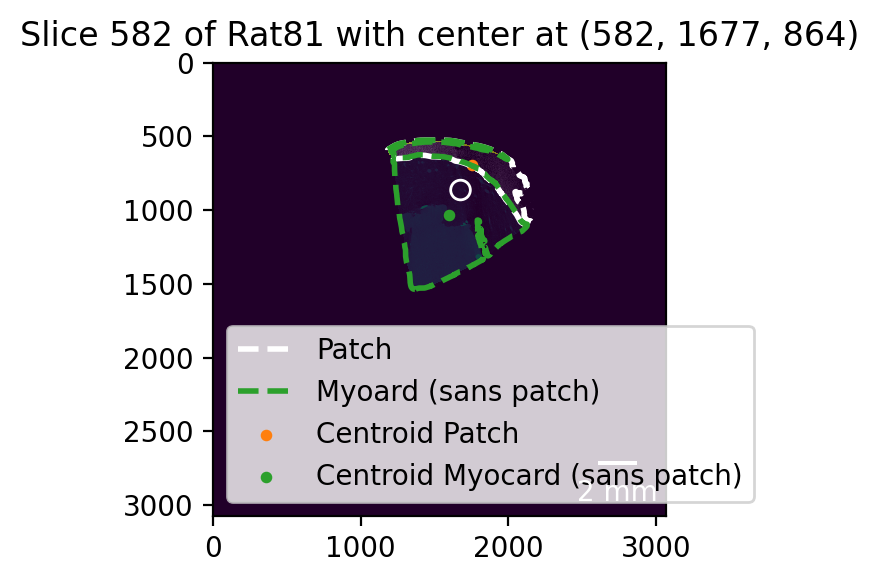

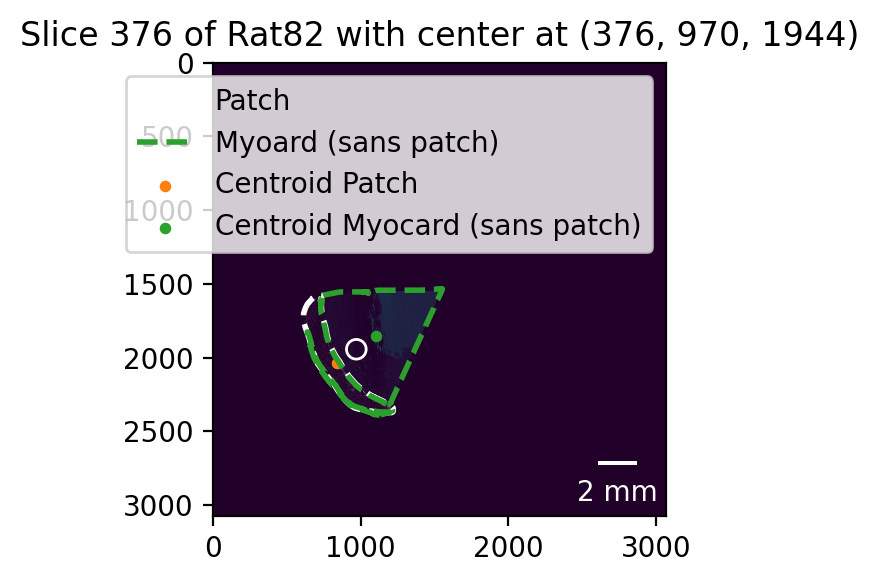

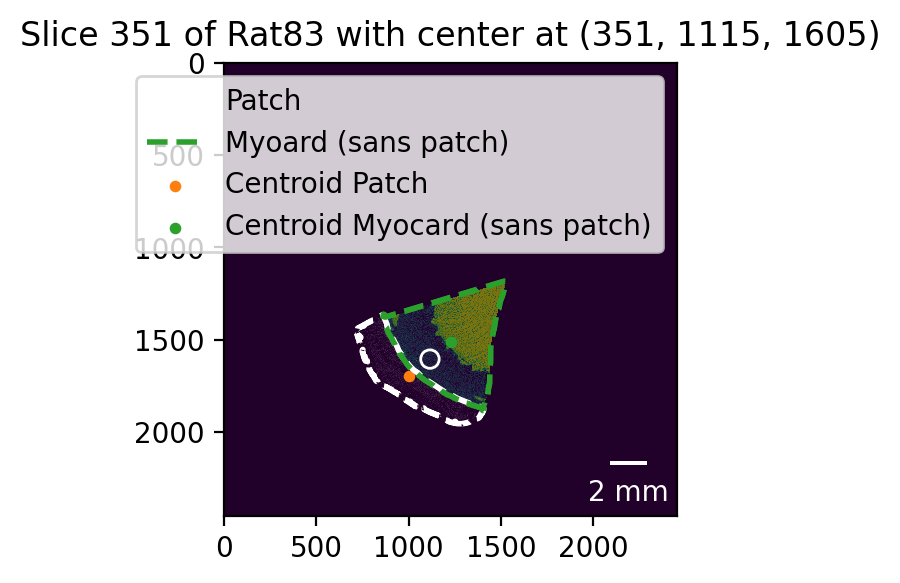

In [314]:
Data['Midpoint'] = ''
for whichone in range(0,len(Data),3):
    # Calculate the midpoint and visualize it *on* the data
    #print(whichone, Data['Sample'][whichone], Data['Scan'][whichone], Data['VOI'][whichone])
    #print(whichone + 1, Data['Sample'][whichone+1], Data['Scan'][whichone+1], Data['VOI'][whichone+1])
    #print(whichone + 2, Data['Sample'][whichone+2], Data['Scan'][whichone+2], Data['VOI'][whichone+2])
    # Display images we're dealing with, e.g. mycard and patch
    plt.imshow(Data['Image'][whichone + 1])
    plt.imshow(Data['Image'][whichone + 2], cmap='viridis', alpha=0.5)
    # Display the relevant contour
    plt.plot(Data['Contour'][whichone + 1][0], Data['Contour'][whichone + 1][1],
             '--',
             lw=2,
             color='w',
             label='Patch')
    plt.plot(Data['Contour'][whichone + 2][0], Data['Contour'][whichone + 2][1],
             '--',
             lw=2,
             color=seaborn.color_palette()[2],
             label='Myoard (sans patch)')
    # Plot the centroids
    plt.scatter(Data['Centroid'][whichone + 1][0], Data['Centroid'][whichone + 1][1],
                color=seaborn.color_palette()[1], s=10, label='Centroid Patch')
    plt.scatter(Data['Centroid'][whichone + 2][0], Data['Centroid'][whichone + 2][1],
                color=seaborn.color_palette()[2], s=10, label='Centroid Myocard (sans patch)')
    plt.legend()
    # Calculate the midpoint and save the (3D) coordinates of it
    mp = midpoint(Data['Centroid'][whichone + 1][0], Data['Centroid'][whichone + 1][1],
                  Data['Centroid'][whichone + 2][0], Data['Centroid'][whichone + 2][1])
    Data.at[whichone + 2, 'Midpoint'] = (Data['Size'][whichone + 1][0]//2,
                                         int(round(mp[0].squeeze())),
                                         int(round(mp[1].squeeze())))
    # Display the cutout region
    radius = 500  # um
    cutoutregion = plt.Circle(mp, radius / Data['Voxelsize'][whichone], fill=False, color='w', label='Cutout')
    plt.gca().add_artist(cutoutregion)
    plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichone], 'um'))
    plt.title('Slice %s of %s with center at %s' % (Data['Size'][whichone][0]//2,
                                                    Data['Sample'][whichone],
                                                    Data['Midpoint'][whichone + 2]))
    # Save the image
    outpath = os.path.join(os.path.dirname(Data['Folder'][whichone]),
                           '%s.CutOutRegion.png' % (Data['Sample'][whichone]))
    if not os.path.exists(outpath):    
        plt.savefig(outpath,
                    bbox_inches='tight')
    plt.show()

In [315]:
Data.Midpoint

0                      
1                      
2      (317, 860, 1254)
3                      
4                      
5      (325, 885, 1113)
6                      
7                      
8     (374, 1517, 1207)
9                      
10                     
11     (522, 1494, 912)
12                     
13                     
14     (368, 741, 1453)
15                     
16                     
17     (438, 1340, 719)
18                     
19                     
20    (520, 1766, 2269)
21                     
22                     
23    (248, 1478, 1700)
24                     
25                     
26     (469, 629, 1348)
27                     
28                     
29     (224, 897, 1429)
30                     
31                     
32    (270, 1288, 2036)
33                     
34                     
35     (403, 725, 1257)
36                     
37                     
38    (464, 1584, 1917)
39                     
40                     
41     (582, 167

Now we can actually cutout the region

TODO:
- Multiply the original data with a sphere of 1 to produce a cutout.
- Nudge position of cutout to a defined depth in the myocard, now it's at the midpoint
- Calculate cutoutregion not as a sphere, but as an ellipsoid

In [316]:
whichsample = 11
img = VOIs[whichsample]
print(Data.Midpoint[whichsample])
print(img.shape)

(522, 1494, 912)
(1045, 3072, 3072)


In [324]:
# Calculate us the region (size) we want to cut out
# Use something like https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.ball
radius = 1000  # um
radius_px = int(round(radius / Data['Voxelsize'][whichsample]))
ball = None
ball = skimage.morphology.ball(radius_px, dtype='bool')# * (2 ** 8 - 1)
print(ball.shape[0])
# plt.imshow(ball[ball.shape[0]//2])
# plt.gca().add_artist(ScaleBar(Data['Voxelsize'][9], 'um', fixed_value=radius, color='red'))
# plt.show()

267


In [325]:
Data.Midpoint[whichsample]

(522, 1494, 912)

In [326]:
radius_px

133

In [327]:
empty = dask.array.zeros_like(img)
print(empty.shape)
print(int(img.shape[0]//2 - radius_px),
      int(img.shape[0]//2 - radius_px + ball.shape[0]))
print(Data.Midpoint[whichsample][0] - radius_px,
      Data.Midpoint[whichsample][0] - radius_px + ball.shape[0])
print(Data.Midpoint[whichsample][1] - radius_px,
      Data.Midpoint[whichsample][1] - radius_px + ball.shape[0])
empty[Data.Midpoint[whichsample][0] - radius_px:Data.Midpoint[whichsample][0] - radius_px + ball.shape[0],
      Data.Midpoint[whichsample][1] - radius_px:Data.Midpoint[whichsample][1] - radius_px + ball.shape[0],
      Data.Midpoint[whichsample][2] - radius_px:Data.Midpoint[whichsample][2] - radius_px + ball.shape[0]] = ball
# Mask image with the ball. Dask masking does *not* return a copy, but a view of the data
dask.array.ma.masked_where(empty==False, img)

(1045, 3072, 3072)
389 656
389 656
1361 1628


dask.array<masked_where, shape=(1045, 3072, 3072), dtype=uint8, chunksize=(11, 3072, 3072), chunktype=numpy.MaskedArray>

In [345]:
def baller(whichone, ball_radius_um=1000, verbose=True):
    ''' Cut out a spherical region at a defined coordinate '''
    # Set up stuff we need
    ## Calculate us the region (size) we want to cut out
    radius_px = int(round(ball_radius_um / Data['Voxelsize'][whichsample]))
    ball = None
    ball = skimage.morphology.ball(radius_px, dtype='bool')# * (2 ** 8 - 1)
    voi = VOIs[whichone]
    empty = dask.array.zeros_like(voi)
    center = Data['Midpoint'][whichone]
    empty[Data.Midpoint[whichsample][0] - radius_px:Data.Midpoint[whichsample][0] - radius_px + ball.shape[0],
          Data.Midpoint[whichsample][1] - radius_px:Data.Midpoint[whichsample][1] - radius_px + ball.shape[0],
          Data.Midpoint[whichsample][2] - radius_px:Data.Midpoint[whichsample][2] - radius_px + ball.shape[0]] = ball
    # Mask image with the ball. Dask masking does *not* return a copy, but a view of the data
    masked_image=dask.array.ma.masked_where(empty==False, voi)
    if verbose:
        for whichaxis in range(3):
            print(center[whichaxis:whichaxis+2])
            plt.subplot(1,3,whichaxis+1)
            plt.imshow(VOIs[whichone].max(axis=whichaxis))
            plt.imshow(voi.max(axis=whichaxis), cmap='viridis')
            plt.title('mip axis %s' % whichaxis)
            plt.axis('off')
        plt.show()
    return(masked_image)

In [347]:
asdfasdfasdfasdf===

SyntaxError: invalid syntax (Temp/ipykernel_20944/2410841197.py, line 1)

(317, 860)
(860, 1254)
(1254,)


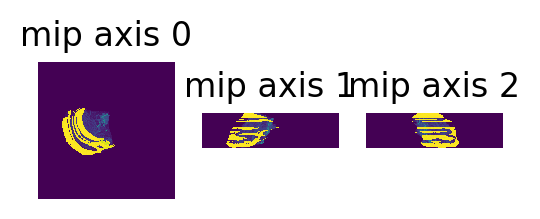

dask.array<masked_where, shape=(635, 2452, 2452), dtype=uint8, chunksize=(22, 2452, 2452), chunktype=numpy.MaskedArray>

In [346]:
baller(2, ball_radius_um=555)

In [329]:
for i in Data:
    print(i)

LogFile
Folder
Sample
Scan
Experiment
Timepoint
Gender
VOI
VOIFolder
VOIFiles
Number of VOI slices
Voxelsize
OutputNameVOI
Image
ROI
Properties
Contour
Centroid
Orientation
Midpoint
Size


In [330]:
Data['Midpoint']

0                      
1                      
2      (317, 860, 1254)
3                      
4                      
5      (325, 885, 1113)
6                      
7                      
8     (374, 1517, 1207)
9                      
10                     
11     (522, 1494, 912)
12                     
13                     
14     (368, 741, 1453)
15                     
16                     
17     (438, 1340, 719)
18                     
19                     
20    (520, 1766, 2269)
21                     
22                     
23    (248, 1478, 1700)
24                     
25                     
26     (469, 629, 1348)
27                     
28                     
29     (224, 897, 1429)
30                     
31                     
32    (270, 1288, 2036)
33                     
34                     
35     (403, 725, 1257)
36                     
37                     
38    (464, 1584, 1917)
39                     
40                     
41     (582, 167

In [336]:
whichone = 11
print(Data.Size[whichone])
print(Data.Midpoint[whichone])
print(Data.Midpoint[whichone])
print(radius,  Data['Voxelsize'][whichone], int(round(radius / Data['Voxelsize'][whichone])))

(1045, 3072, 3072)
(522, 1494, 912)
(522, 1494, 912)
1000 7.500482 133


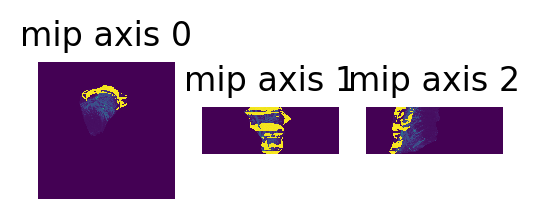

In [332]:
baller(img, 1, 1)

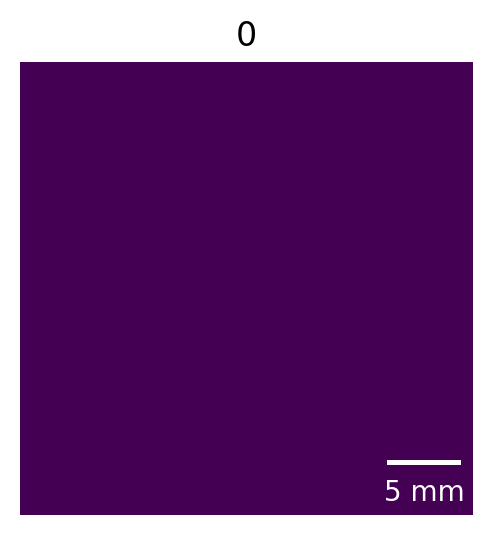

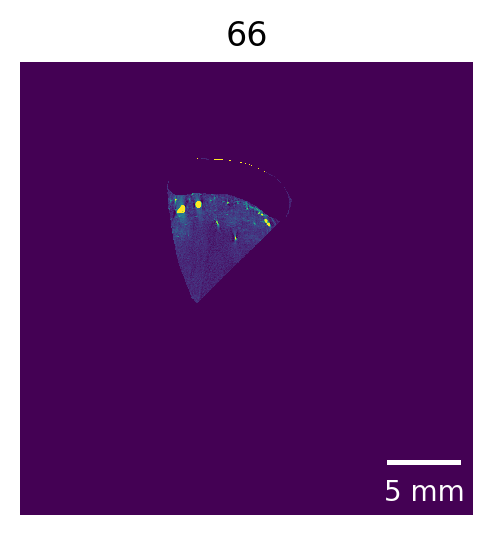

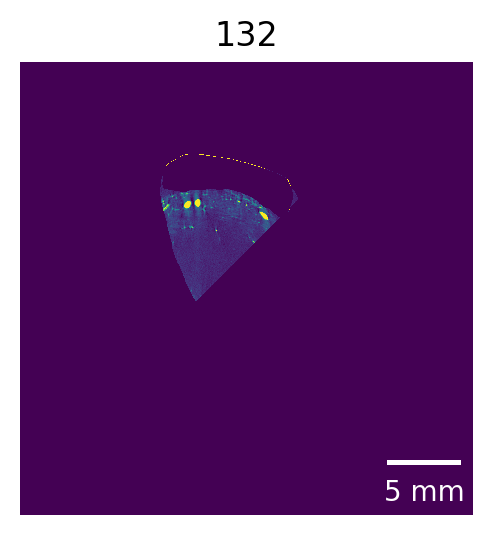

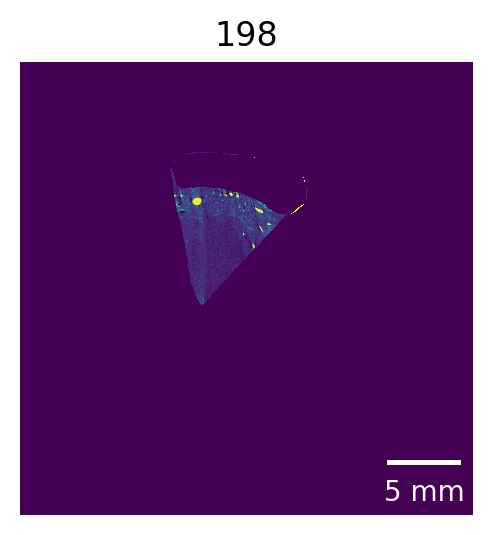

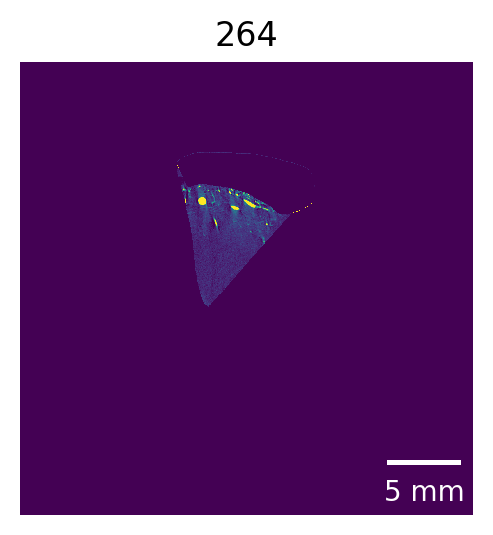

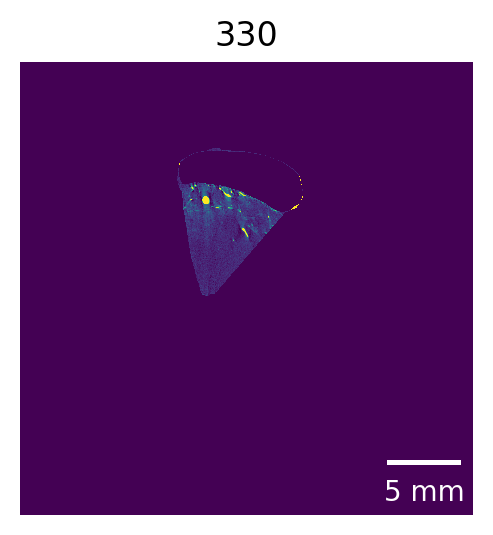

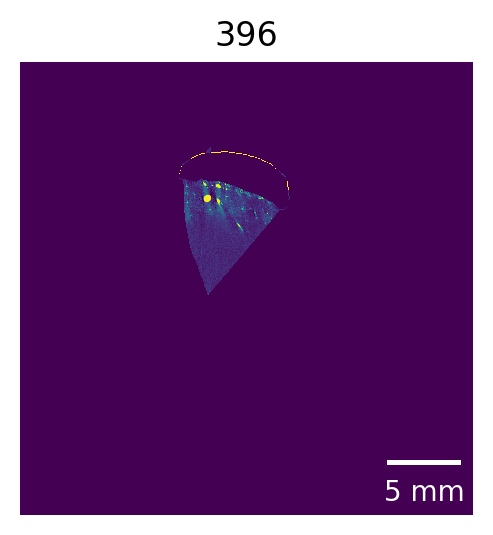

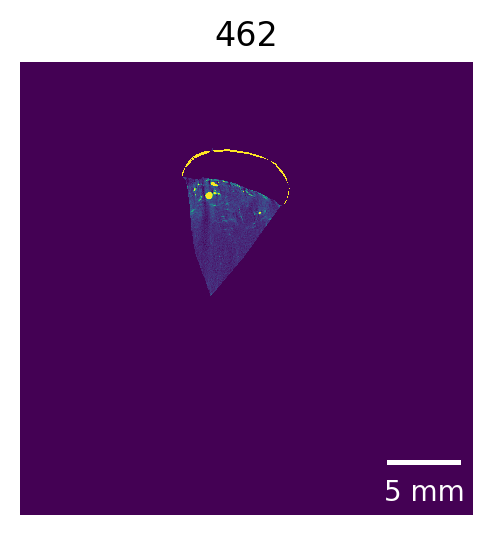

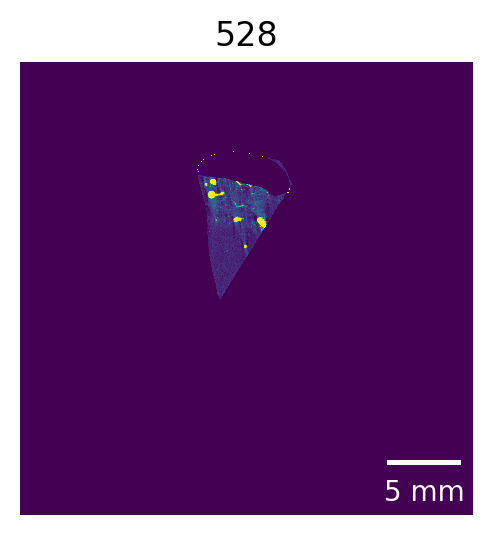

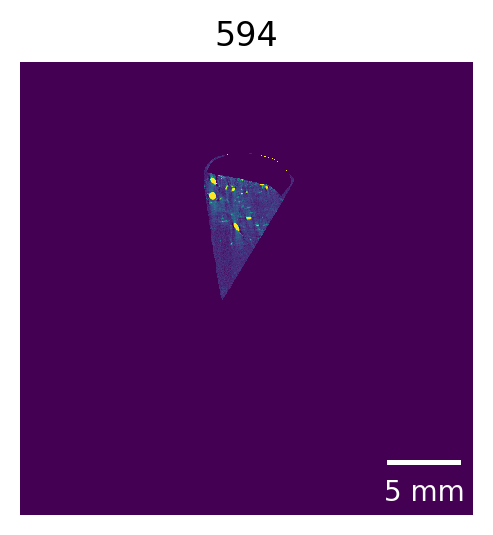

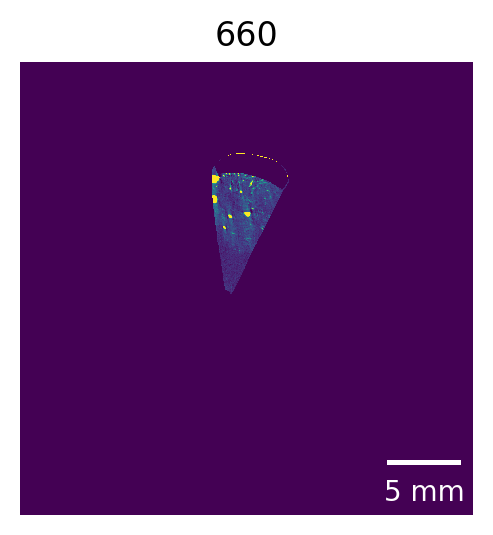

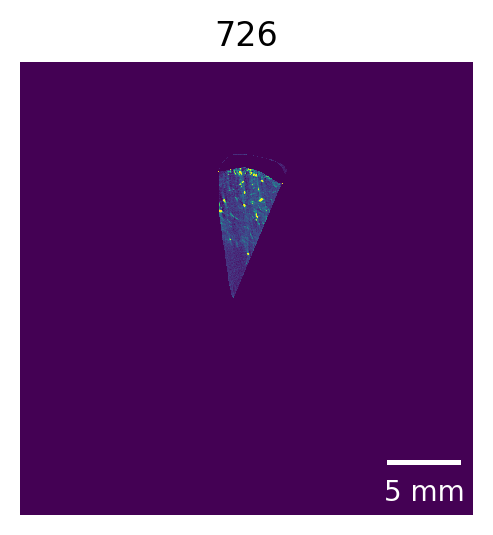

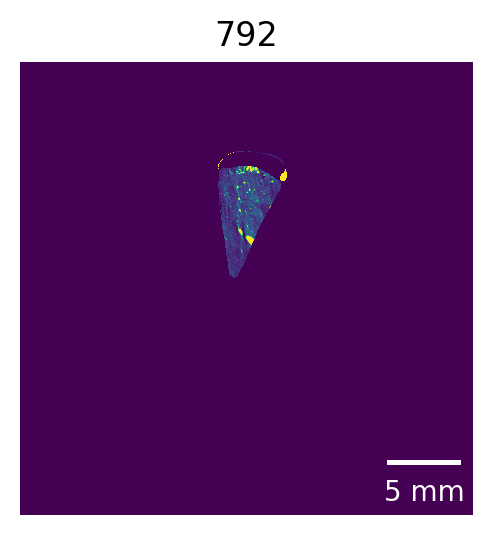

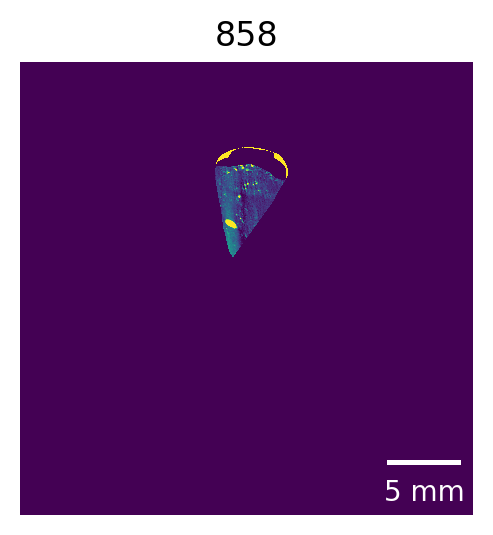

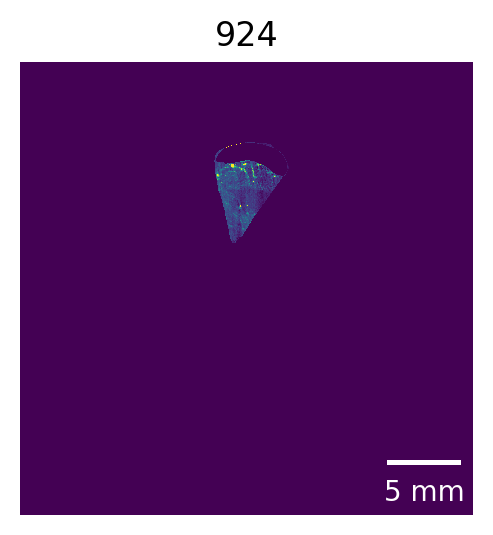

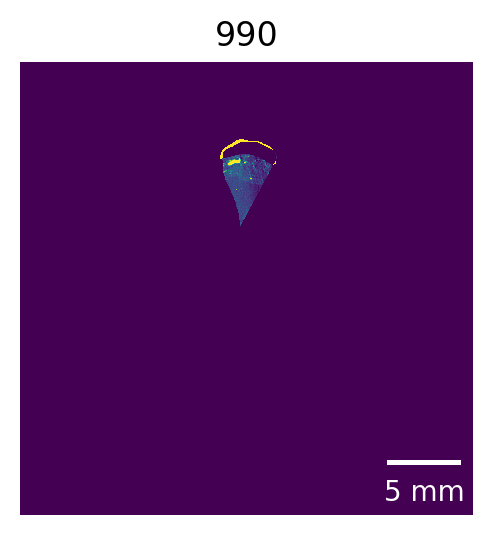

In [333]:
for i in range(len(img)):
    if not i % 66:
        plt.imshow(img[i], vmax=50, cmap='viridis')
        plt.axis('off')
        plt.gca().add_artist(ScaleBar(Data['Voxelsize'][12], 'um'))
        plt.title(i)
        plt.show()

https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.ball

Let's try to use `shapely` to find the intersections we need.
Something along the lines of https://newbedev.com/what-is-most-efficient-way-to-find-the-intersection-of-a-line-and-a-circle-in-python

In [ ]:
from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.geometry import asLineString

p = Point(5,5)
c = p.buffer(3.5).boundary
l = LineString([(0,0), (10, 10)])
i = c.intersection(l)

print(i.geoms[0].coords[0])
print(i.geoms[1].coords[0])

In [ ]:
# Convert skimage measure contour to shapely polygon
# https://gis.stackexchange.com/a/403004/164845
outline = Polygon(list(zip(Data['Contour'][3][0], Data['Contour'][3][1])))

In [ ]:
# Convert centerpoint coordinates to shapely line
ls = (Data['Centroid'][2][0], Data['Centroid'][3][0]),(Data['Centroid'][2][1], Data['Centroid'][3][1])
line = LineString(ls)

In [ ]:
# Find intersection of line with contour
intersection = line.intersection(outline)

In [ ]:
intersection

In [ ]:
plt.plot(outline.exterior.xy[0], outline.exterior.xy[1])
plt.plot(ls[0], ls[1])
plt.show()

In [ ]:
line

In [ ]:
line

In [ ]:
intersection

In [ ]:
c = plt.Circle(( 5 ,5 ), 3.5, alpha=0.5)
plt.plot((0,10), (0, 10))
plt.gca().add_artist(c)
plt.scatter(i.geoms[0].coords[0][0], i.geoms[0].coords[0][0], c='r')
plt.scatter(i.geoms[1].coords[0][0], i.geoms[1].coords[0][0], c='r')
plt.axis('equal')
plt.show()

In [ ]:
from shapely.geometry import LineString
ls = (Data['Centroid'][2][0].squeeze(), Data['Centroid'][3][0].squeeze()),(Data['Centroid'][2][1].squeeze(), Data['Centroid'][3][1].squeeze())
line = LineString(ls)
print(line.length)

In [ ]:
contour = Data['Contour'][3]
plt.plot(contour[0].squeeze(), contour[1].squeeze())
plt.plot((Data['Centroid'][2][0].squeeze(), Data['Centroid'][3][0].squeeze()),
         (Data['Centroid'][2][1].squeeze(), Data['Centroid'][3][1].squeeze()), lw=3, color='b')
plt.axis('equal')
plt.show()

In [ ]:
# Display line from patch to myocard
# images
plt.imshow(Data['Image'][2])
plt.imshow(Data['Image'][3], cmap='viridis', alpha=0.5)
# contour
plt.plot(Data['Contour'][2][0], Data['Contour'][2][1], lw=1, c='r')
plt.plot(Data['Contour'][3][0], Data['Contour'][3][1], lw=1, c='g')
# Centroids
plt.scatter(Data['Centroid'][2][0], Data['Centroid'][2][1], marker=None, color='w')
plt.scatter(Data['Centroid'][3][0], Data['Centroid'][3][1], marker=None, color='w')
# Line between centroids
plt.plot([Data['Centroid'][2][0], Data['Centroid'][3][0]],
         [Data['Centroid'][2][1], Data['Centroid'][3][1]], lw=3, color='b')
# Details
plt.title('%s: %s: %s and %s' % (Data['Sample'][2], Data['Scan'][2], Data['VOI'][2], Data['VOI'][3]))
plt.gca().add_artist(ScaleBar(Data['Voxelsize'][2], 'um'))
plt.show()

In [ ]:
SelectedSample = 7
# ONLY SELECT EVEN/ODD IMGS
if not(SelectedSample % 2):
    SelectedSample -= 1
    if SelectedSample < 0:
        SelectedSample = 1
print(SelectedSample)
# Select middle slice
patch = VOIs[SelectedSample][VOIs[SelectedSample].shape[0]//2].compute()
myocard = VOIs[SelectedSample-1][VOIs[SelectedSample-1].shape[0]//2].compute()
plt.subplot(121)
plt.imshow(patch)
plt.imshow(myocard, alpha=.5)
plt.subplot(122)
plt.imshow(myocard)
plt.imshow(patch, alpha=0.5, cmap='viridis')
plt.show()

In [ ]:
# Display
fig = plt.imshow(patch, alpha=.5)
plt.imshow(myocard, alpha=.5, cmap='viridis')
whichlengthdowewant = 2000
length= whichlengthdowewant / Data['Voxelsize'][SelectedSample] # um

    # Scake bar
    plt.gca().add_artist(ScaleBar(Data['Voxelsize'][SelectedSample], 'um'))
# plt.savefig('orientation.png', bbox_inches='tight')
plt.axis('off')
plt.show()

In [ ]:
props = measure.regionprops(labels, img)
properties = ['area', 'eccentricity', 'perimeter']

# For each label, add a filled scatter trace for its contour,
# and display the properties of the label in the hover of this trace.
for index in range(1, labels.max()):
    label_i = props[index].label
    contour = measure.find_contours(labels == label_i, 0.5)[0]
    y, x = contour.T
    hoverinfo = ''
    for prop_name in properties:
        hoverinfo += f'<b>{prop_name}: {getattr(props[index], prop_name):.2f}</b><br>'


In [ ]:
plt.subplot(121)
plt.imshow(img)
plt.imshow(roi, alpha=0.5, cmap='viridis')
plt.subplot(122)
plt.axis('off')
plt.imshow(img)
for r in regions:
    # plot equivalent diameter: https://stackoverflow.com/a/9216646/323100
    circle = plt.Circle((r.centroid[1], r.centroid[0]), r.equivalent_diameter * 0.5, alpha=0.309)
    plt.gca().add_artist(circle)
    plt.gca().text(r.centroid[1]+5, r.centroid[0]-5, r.area, fontsize=12, color='lightgray')    
    # scatterplot the centroid over this
    plt.scatter(r.centroid[1], r.centroid[0])
plt.axis('off')
plt.show()

In [ ]:
plt.subplot(121)
for r in regions:
    plt.imshow(LabelledImage)
    # plot equivalent diameter: https://stackoverflow.com/a/9216646/323100
    circle = plt.Circle((r.centroid[1], r.centroid[0]), r.equivalent_diameter * 0.5, alpha=0.309)
    plt.gca().add_artist(circle)
    plt.gca().text(r.centroid[1]+5, r.centroid[0]-5, r.area, fontsize=12, color='lightgray')    
    # scatterplot the centroid over this
    plt.scatter(r.centroid[1], r.centroid[0])
    plt.title('%s detected areas with equivalent circle, centroid and area' % NumLabels)
plt.subplot(122)
plt.hist(Areas, bins=32, log=True)
plt.show()

In [ ]:
def drawasquare(image, voxelsize, squaresidelength=100, angle=33):
    '''draw a square with x um sidelength on the image'''
    from matplotlib.patches import Rectangle
    imagesize = image.shape
    print(type(imagesize))
    center = tuple([v//2 for v in imagesize])
    print(type(center))
    print(image.shape)
    print(center)
    #
    print('Get the schwerpunkt of the ROI')
    # skimage.measure.regionprops
    # Get image size, so we know where to draw how big
    plt.gca().add_patch(Rectangle((500,100), 333,222,
                                  angle=angle,
                                  edgecolor='red',
                                  facecolor='green',
                                  lw=3))
    plt.imshow(image)
    plt.imshow(image>0, alpha=0.5, cmap='viridis')
    return()

In [ ]:
# Show cube on image
for c, row in Data.iterrows():
    for d, direction in enumerate(directions):
        plt.subplot(1, 3, d + 1)
        plt.imshow(row['MIP_' + direction])
        drawasquare(row['MIP_' + direction], row.Voxelsize)
        plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
        plt.title('%s, %s' % (os.path.join(row['Sample'], row['VOI']),
                              direction + ' MIP'))
        plt.axis('off')
        plt.show()

In [ ]:
import numpy as np
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [ ]:
Data.head()

In [ ]:
# Read or calculate the directional MIPs, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['MIP_' + direction] = [None] * len(VOIs)
for c, row in notebook.tqdm(Data.iterrows(), desc='MIPs', total=len(Data)):
    for d, direction in notebook.tqdm(enumerate(directions),
                                      desc=os.path.join(row['Sample'], row['VOI']),
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(os.path.dirname(row['Folder']),
                                   '%s.%s.%s.MIP.%s.png' % (row['Sample'],
                                                            row['Scan'],
                                                            row['VOI'],
                                                            direction))
        if os.path.exists(outfilepath):
            Data.at[c,'MIP_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate MIP
            Data.at[c,'MIP_' + direction] = VOIs[c].max(axis=d).compute()
            # Save it out
            imageio.imwrite(outfilepath, Data.at[c,'MIP_' + direction].astype('uint8'))

In [ ]:
# Show MIP slices
for c, row in Data.iterrows():
    outpath = os.path.join(os.path.dirname(row['Folder']), '%s.%s.MIPs.png' % (row['Sample'], row['VOI']))
    if not os.path.exists(outpath):    
        for d, direction in enumerate(directions):
            plt.subplot(1, 3, d + 1)
            plt.imshow(row['MIP_' + direction])
            plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
            plt.title('%s, %s' % (os.path.join(row['Sample'], row['VOI']),
                                  direction + ' MIP'))
            plt.axis('off')
        plt.savefig(outpath,
                    bbox_inches='tight')
        plt.show()

The `mean` gray value needs to be calculated and 'calibrated' to the total volume of the ROI

In [ ]:
# Mask the outside of the ROI that Tim drew
Masked = [dask.array.ma.masked_equal(v, 0) for v in VOIs]

In [ ]:
# How large are the VOIs from Tim?
# We select/mask everything non-zero and fill this whith one.
VOIRegion = [dask.array.ma.filled(dask.array.ma.masked_not_equal(v, 0),
                                  1) for v in VOIs]
# By summing it, we get the volume in voxels
# This computation takes a *long* time
Data['VOIVolume_voxel'] = [vr.sum().compute() for vr in VOIRegion]
# Calculate the physical volume of the VOIs in ul
Data['VOIVolume'] = [vv * vs**3 for vv, vs in zip(Data['VOIVolume_voxel'], Data['Voxelsize'])]

In [ ]:
whichone = 6
whichslice = 111
plt.subplot(131)
plt.imshow(Masked[whichone][whichslice])
plt.title('Mask %s/%s' % (Data.Sample[whichone], Data.VOI[whichone]))
plt.subplot(132)
plt.imshow(VOIRegion[whichone][whichslice])
plt.title('VOI %s/%s' % (Data.Sample[whichone], Data.VOI[whichone]))
plt.subplot(133)
plt.imshow(VOIs[whichone][whichslice])
plt.title('Original %s/%s' % (Data.Sample[whichone], Data.VOI[whichone]))
plt.savefig(os.path.join(OutputDir, 'VOI.%s.%s.png' % (Data.Sample[whichone], Data.VOI[whichone])),
            transparent=False,
            bbox_inches='tight')
plt.show()

In [ ]:
Data[Data.VOI == 'patch'].head()

In [ ]:
Data[Data.VOI == 'myocard']

In [ ]:
for c, exp in enumerate(Data.Experiment.unique()):
    print(c, exp)

In [ ]:
# Plot volume of VOIs for comparison
for c, which in enumerate(['patch', 'myocard']):
    plt.subplot(1,2,c+1)
    seaborn.swarmplot(data=Data[Data.VOI == which],
                  x='Experiment',
                  y='VOIVolume',
                  dodge=True,
                  hue='Timepoint',
                  s=10,
                  linewidth=1.5)
    for c, row in Data[Data.VOI == which].iterrows():      
        if 'V+P' in row.Experiment:
            plt.annotate(row.Sample, (0, row.VOIVolume))
        elif 'F' in row.Experiment:
            plt.annotate(row.Sample, (1, row.VOIVolume))
        elif 'tacho' in row.Experiment:
            plt.annotate(row.Sample, (2, row.VOIVolume))
        elif row.Experiment == 'V':
            plt.annotate(row.Sample, (3, row.VOIVolume))
    # plt.ylim([0, 4e8])
    plt.title('Volume of the individual %s VOIs' % which)
plt.savefig(os.path.join(OutputDir, 'Volume.VOIs.png'),
            transparent=False,
            bbox_inches='tight')
plt.show()

In [ ]:
# Plot volume of VOIs for comparison
for c,which in enumerate(['patch', 'myocard']):
    seaborn.swarmplot(data=Data[Data.VOI == which],
                  x='Experiment',
                  y='VOIVolume',
                  dodge=True,
                  hue='Timepoint',
                  s=10,
                  linewidth=1.5)
    for c,row in Data[Data.VOI == which].iterrows():
        if 'V+P' in row.Experiment:
            plt.annotate(row.Sample, (0, row.VOIVolume))
        elif 'F' in row.Experiment:
            plt.annotate(row.Sample, (1, row.VOIVolume))
        elif 'tacho' in row.Experiment:
            plt.annotate(row.Sample, (2, row.VOIVolume))
        elif row.Experiment == 'V':
            plt.annotate(row.Sample, (3, row.VOIVolume))
#     plt.ylim([0, 4e8])
    plt.title('Volume of the %s VOIs' % which)
    plt.savefig(os.path.join(OutputDir, 'Volume.VOIs.%s.png' % which),
                transparent=False,
                bbox_inches='tight')
    plt.show()

In [ ]:
get_git_hash()

In [ ]:
for sample in Data.Sample.unique():
    print(Data[Data.Sample == sample][['Sample', 'Scan', 'Experiment', 'VOIVolume']])
    print(80*'-')

In [ ]:
Data[['Sample',
      'Scan',
      'Experiment',
      'VOI',
      'VOIVolume']].to_excel(os.path.join(OutputDir, 'Volume.VOIs.xlsx'))

In [ ]:
# Data.groupby(by=[['Experiment', 'VOI']])['VOIVolume'].describe()[['count',
#                                                                   'mean',
#                                                                   'std',
#                                                                   'min',
#                                                                   'max']]

In [ ]:
# Save mean of reconstruction gray values,
# We can use this for getting an overview of the image data
Data['GrayValueMean'] = [m.mean().compute() for m  in Masked]

In [ ]:
# Plot mean gray value VOIs for comparison
for c, which in enumerate(['patch', 'myocard']):
    plt.subplot(1,2,c+1)
    seaborn.swarmplot(data=Data[Data.VOI == which],
                      x='Experiment',
                      y='GrayValueMean',
                      hue='Timepoint',
                      s=10,
                      linewidth=1.5,
                      dodge=True)
    for c,row in Data[Data.VOI == which].iterrows():
        if 'V+P' in row.Experiment:
            plt.annotate(row.Sample, (0, row.GrayValueMean))
        elif 'F' in row.Experiment:
            plt.annotate(row.Sample, (1, row.GrayValueMean))
        elif 'tacho' in row.Experiment:
            plt.annotate(row.Sample, (2, row.GrayValueMean))
        elif row.Experiment == 'V':
            plt.annotate(row.Sample, (3, row.GrayValueMean))
    plt.title('Average grayvalue in the %s VOIs' % which)
plt.savefig(os.path.join(OutputDir, 'Grayvalues.Mean.VOIs.png'),
            transparent=False,           
            bbox_inches='tight')
plt.show()

In [ ]:
Data[['Sample', 'GrayValueMean']].to_excel(os.path.join(OutputDir, 'Grayvalues.Mean.VOIs.xlsx'))

In [ ]:
Data.groupby(by=['Experiment'])['GrayValueMean'].describe()[['count',
                                                             'mean',
                                                             'std',
                                                             'min',
                                                             'max']]

In [ ]:
Data['GrayValueMeanNormalizedToVOIVolume'] = [numpy.divide(gvm,
                                                           vv) for gvm, vv in zip(Data['GrayValueMean'],
                                                                                  Data['VOIVolume'])]

In [ ]:
# Plot volume-normalized mean of datasets for comparison
#seaborn.boxplot(data=Data, x='Experiment', y='GrayValueMeanNormalizedToVOIVolume', hue='Timepoint')
seaborn.swarmplot(data=Data, x='Experiment', y='GrayValueMeanNormalizedToVOIVolume', hue='Timepoint', dodge=True, linewidth=1.5, s=10)
for c,row in Data.iterrows():
    if 'VP' in row.Experiment:
        plt.annotate(row.Sample, (5, row.GrayValueMeanNormalizedToVOIVolume))
    elif 'F' in row.Experiment:
        plt.annotate(row.Sample, (1, row.GrayValueMeanNormalizedToVOIVolume))
    elif 'Tacho' in row.Experiment:
        plt.annotate(row.Sample, (2, row.GrayValueMeanNormalizedToVOIVolume))
plt.ylim(ymin=0, ymax=1.1*Data.GrayValueMeanNormalizedToVOIVolume.max())
plt.title('Averaged VOI grayvalue normalized to VOI volume')
plt.savefig(os.path.join(OutputDir, 'Grayvalues.Mean.NormalizedVOI.png'),
            bbox_inches='tight')
plt.show()

In [ ]:
OutputDir

In [ ]:
# Calculate STD of reconstruction gray values, which we can use for getting an overview of the image data
Data['GrayValueSTD'] = [m.std().compute() for m in Masked]

In [ ]:
# # Plot STD of datasets for comparison
seaborn.catplot(data=Data, kind='box', x='Experiment', y='GrayValueSTD')
seaborn.swarmplot(data=Data, x='Experiment', y='GrayValueSTD', linewidth=1.5, s=10)
plt.ylim(ymin=0)
plt.title('STD of gray values')
plt.savefig(os.path.join(OutputDir, 'Grayvalues.STD.png'),
            bbox_inches='tight')
plt.show()

In [ ]:
# def calculate_threshold(img, verbose=False):
#     '''
#     Calculate (Otsu) threshold of a stack, with some nice output if desired
#     '''
#     if len(numpy.shape(img)) != 3:
#         print('Only works with a 3D stack')
#         return()
#     if verbose:
#         print('The stack we use has a size of %s x %s x %s px' % numpy.shape(img))
#     threshold = skimage.filters.threshold_otsu(dask.array.ravel(img.compute()))
#     if verbose:
#         seaborn.distplot(img.ravel())
#         plt.axvline(threshold, label='Otsu@%s' % threshold, c=seaborn.color_palette()[1])
#         plt.axvline(numpy.mean(img), label='Image mean@%0.2f' % img.mean(), c=seaborn.color_palette()[2])
#         plt.legend()
#         plt.semilogy()
#         plt.xlim([0,255])
#         plt.show()
#     return(threshold.compute())

In [ ]:
# # https://stackoverflow.com/a/38086839
# h,bins=dask.array.histogram(VOIs[0], bins=range(0,255,4))
# plt.semilogy(h)
# plt.show()

In [ ]:
skimage.filters.threshold_otsu(
    dask.array.ma.masked_less(rec,1)[333].compute().ravel()
    )

In [ ]:
# Thresholds
preset = True
if preset:
    # Set them (from previous calculations)
    Data['Threshold'] = [19,
 13,
 78,
 63,
 22,
 15,
 26,
 12,
 21,
 4,
 29,
 5,
 35,
 31,
 5,
 17,
 24,
 5,
 8,
 28,
 12,
 24,
 55,
 55,
 34,
 15,
 31,
 7,
 7,
 31,
 40,
 135]
 #    Data['Threshold'] = [44, 46, 41, 16, 12, 15, 63, 16, 15, 18, 13, 13]
#     Data['Threshold'] = [41, 45, 41, 12, 13, 19, 13]
else:
    # Calculate Threshold
    Data['Threshold'] = [skimage.filters.threshold_otsu(
            dask.array.ma.masked_less(rec, 1).compute().ravel()
        ) for rec in VOIs]

In [ ]:
list(Data.Threshold)

In [ ]:
# Get the mean threshold of all samples
Data['ThresholdMean'] = int(Data['Threshold'].mean())

In [ ]:
# Plot the thresholds
seaborn.swarmplot(data=Data, x='Experiment', y='Threshold', hue='Timepoint', dodge=True, linewidth=1.5, s=10)
for c,row in Data.iterrows():
    if 'VP' in row.Experiment:
        plt.annotate(row.Sample, (0, row.Threshold))
    elif 'F' in row.Experiment:
        plt.annotate(row.Sample, (1, row.Threshold))
    elif 'Tacho' in row.Experiment:
        plt.annotate(row.Sample, (2, row.Threshold))
plt.axhline(Data['ThresholdMean'].mean(), label='Mean threshold @ %s' % Data['ThresholdMean'].mean())
plt.ylim(ymin=0)
plt.legend()
plt.title('Otsu thresholds of individual VOIs')
plt.savefig(os.path.join(OutputDir, 'Thresholds.png'),
            bbox_inches='tight')
plt.show()

In [ ]:
Data[['Sample', 'Threshold']].to_excel(os.path.join(OutputDir, 'Thresholds.xlsx'))

In [ ]:
Data.groupby(by=['Experiment'])['Threshold'].describe()[['count',
                                                         'mean',
                                                         'std',
                                                         'min',
                                                         'max']]

In [ ]:
# Threshold the reconstructions individually                                                                                                                           Data.Sample)
Data['OutputNameThresholded'] = [f.replace('.zarr',
                                           '_thresholded_%s.zarr' % str(t).zfill(3)) for f, t in zip(Data['OutputNameVOI'],
                                                                                                     Data['Threshold'])]
for c, row in Data.iterrows():
    if os.path.exists(row['OutputNameThresholded']):  
        print('%2s/%s: Already saved to %s' % (c + 1,
                                               len(Data),
                                               row['OutputNameThresholded'][len(Root):]))
    else:
        print('%2s/%s: Thresholding and saving to %s' % (c + 1,
                                                         len(Data),
                                                         row['OutputNameThresholded'][len(Root):]))
        Thresholded = VOIs[c] > row['Threshold']
        Thresholded.rechunk('auto').to_zarr(row['OutputNameThresholded'],
                                            compressor=Blosc(cname='zstd',
                                                             clevel=9,
                                                             shuffle=Blosc.BITSHUFFLE))    

In [ ]:
# Threshold the reconstructions with the mean threshold                                                                                                                           Data.Sample)
Data['OutputNameThresholdedMean'] = [f.replace('.zarr',
                                           '_thresholded_%s.zarr' % str(t).zfill(3)) for f, t in zip(Data['OutputNameVOI'],
                                                                                                     Data['ThresholdMean'])]
for c, row in Data.iterrows():
    if os.path.exists(row['OutputNameThresholdedMean']):  
        print('%2s/%s: Already saved to %s' % (c + 1,
                                               len(Data),
                                               row['OutputNameThresholdedMean'][len(Root):]))
    else:
        print('%2s/%s: Thresholding and saving to %s' % (c + 1,
                                                         len(Data),
                                                         row['OutputNameThresholded'][len(Root):]))
        Thresholded = VOIs[c] > row['ThresholdMean']
        Thresholded.rechunk('auto').to_zarr(row['OutputNameThresholdedMean'],
                                            compressor=Blosc(cname='zstd',
                                                             clevel=9,
                                                             shuffle=Blosc.BITSHUFFLE))    

In [ ]:
# Load the DASK arrays of the thresholded samples
individualThreshold = True
if individualThreshold:
    Thresholded = [dask.array.from_zarr(file) for file in Data['OutputNameThresholded']]
    print('Loading individually thresholded stacks')
else:
    Thresholded = [dask.array.from_zarr(file) for file in Data['OutputNameThresholdedMean']]
    print('Loading all stacks with a threshold of %s' % Data.ThresholdMean.unique())

In [ ]:
# DASK
# Read or calculate the middle slices of the thresholded images,
# put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['Thresholded_Mid_' + direction] = [None] * len(VOIs)
for c, row in notebook.tqdm(Data.iterrows(),
                                 desc='Middle thresholded images',
                                 total=len(Data)):
    for d, direction in notebook.tqdm(enumerate(directions),
                                           desc=row['Sample'],
                                           leave=False,
                                           total=len(directions)):
        outfilepath = os.path.join(row['Folder'],
                                   '%s.Thresholded%03d.Middle.%s.png' % (row['Sample'],
                                                                         row['Threshold'],
                                                                         direction))
        if os.path.exists(outfilepath):
            Data.at[c,'Thresholded_Mid_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate requested axial view
            if 'Axial' in direction:
                Data.at[c,'Thresholded_Mid_' + direction] = Thresholded[c][Data['Size'][c][0]//2]
            if 'Sagittal' in direction:
                Data.at[c,'Thresholded_Mid_' + direction] = Thresholded[c][:,Data['Size'][c][1]//2,:]
            if 'Coronal' in direction:
                Data.at[c,'Thresholded_Mid_' + direction] = Thresholded[c][:,:,Data['Size'][c][2]//2]
            # Save the calculated 'direction' view out
            # Dask only calculates/reads the images here at this point...
            imageio.imwrite(outfilepath, (Data.at[c,'Thresholded_Mid_' + direction].astype('uint8')*255))

In [ ]:
# for d, direction in enumerate(directions):
#     for c,row in Data.iterrows():
#         plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
#         plt.imshow(row['Thresholded_Mid_' + direction])
#         plt.title('%s\nMid-%s\nthresholded slice' % (row['Sample'], direction))
#         plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))    
#         plt.axis('off')
#     plt.show()

In [ ]:
# Read or calculate the directional MIPs of the thresholded datasets,
# put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['Thresholded_MIP_' + direction] = [None] * len(VOIs)
for c, row in notebook.tqdm(Data.iterrows(), desc='MIPs', total=len(Data)):
    for d, direction in notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(row['Folder'], '%s.Thresholded.MIP.%s.png' % (row['Sample'], direction))
        if os.path.exists(outfilepath):
            Data.at[c,'Thresholded_MIP_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate MIP
            Data.at[c,'Thresholded_MIP_' + direction] = Thresholded[c].max(axis=d).compute()
            # Save it out
            imageio.imwrite(outfilepath, Data.at[c,'Thresholded_MIP_' + direction].astype('uint8'))            

In [ ]:
# Show thresholded MIP slices
for c, row in Data.iterrows():
    for d, direction in enumerate(directions):
        plt.subplot(1, 3, d + 1)
        plt.imshow(row['Thresholded_MIP_' + direction])
        plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
#         plt.title('%s/%s: %s, %s' % (c + 1,
#                                      len(Data),
#                                      row['Sample'],
#                                      direction + ' MIP'))
        plt.title('%s, %s' % (row['Sample'], direction + ' MIP'))
        plt.axis('off')
    plt.savefig(os.path.join(row['Folder'], row['Sample'] + '.Thresholded.MIPs.png'),
                bbox_inches='tight')
    plt.show()

In [ ]:
# Sum the images, so we can see if they contain approximately the same *thresholded* volume
Data['ThresholdedVolume'] = [th.sum().compute() for th in Thresholded]

In [ ]:
# Data[['Sample', 'ThresholdedVolume']]

In [ ]:
# Plot the thresholded volumes
seaborn.swarmplot(data=Data, x='Experiment', y='ThresholdedVolume', hue='Timepoint', dodge=True, linewidth=1.5, s=10)
for c,row in Data.iterrows():
    if 'VP' in row.Experiment:
        plt.annotate(row.Sample, (0, row.ThresholdedVolume))
    elif 'F' in row.Experiment:
        plt.annotate(row.Sample, (1, row.ThresholdedVolume))
    elif 'Tacho' in row.Experiment:
        plt.annotate(row.Sample, (2, row.ThresholdedVolume))
plt.ylim(ymin=0)
if individualThreshold:
    plt.title('Volume of the individually thresholded images, corresponding to the total thresholded volume')
    plt.savefig(os.path.join(OutputDir, 'Volumes.Thresholded.ThresholdedIndividually.png'),
                bbox_inches='tight')    
else:
    plt.title('Volume of the images thresholded all equally, corresponding to the total thresholded volume')    
    plt.savefig(os.path.join(OutputDir, 'Volumes.Thresholded.ThresholdedEqually.png'),
                bbox_inches='tight')    
plt.show()

In [ ]:
OutputDir

In [ ]:
# Data[['Sample', 'Experiment', 'Threshold', 'ThresholdedVolume', 'GrayValueMean']]

In [ ]:
Data['GrayValueMeanNormalizedToThresholdedVolume'] = [numpy.divide(gvm,
                                                                   tv) for gvm, tv in zip(Data['GrayValueMean'],
                                                                                          Data['ThresholdedVolume'])]

In [ ]:
# view(Thresholded[3].astype('uint8'))

In [ ]:
# Plot volume-normalized mean of datasets for comparison
seaborn.swarmplot(data=Data, x='Experiment', y='GrayValueMeanNormalizedToThresholdedVolume', hue='Timepoint', dodge=True, linewidth=1.5, s=10)
for c,row in Data.iterrows():
    if 'VP' in row.Experiment:
        plt.annotate(row.Sample, (0, row.GrayValueMeanNormalizedToThresholdedVolume))
    elif 'F' in row.Experiment:
        plt.annotate(row.Sample, (1, row.GrayValueMeanNormalizedToThresholdedVolume))
    elif 'Tacho' in row.Experiment:
        plt.annotate(row.Sample, (2, row.GrayValueMeanNormalizedToThresholdedVolume))
plt.ylim(ymin=0, ymax=Data.GrayValueMeanNormalizedToThresholdedVolume.max())
if individualThreshold:
    plt.title('Average grayvalue normalized to the thresholded volume')
    plt.savefig(os.path.join(OutputDir, 'Grayvalues.Mean.NormalizedToThresholded.ThresholdedIndividually.png'),
            bbox_inches='tight')   
else:
    plt.title('Average grayvalue normalized to the volume thresholded all with the same threshold')        
    plt.savefig(os.path.join(OutputDir, 'Grayvalues.Mean.NormalizedToThresholded.ThresholdedEqually.png'),
                bbox_inches='tight')    
plt.show()

In [ ]:
# # Plot volume-normalized mean of datasets for comparison
# seaborn.swarmplot(data=Data, x='Experiment', y='GrayValueMeanNormalizedToThresholdedVolume', hue='Timepoint', dodge=True, linewidth=1.5, s=10)
# for c,row in Data.iterrows():
#     if 'VP' in row.Experiment:
#         plt.annotate(row.Sample, (0, row.GrayValueMeanNormalizedToThresholdedVolume))
#     elif 'F' in row.Experiment:
#         plt.annotate(row.Sample, (1, row.GrayValueMeanNormalizedToThresholdedVolume))
#     elif 'Tacho' in row.Experiment:
#         plt.annotate(row.Sample, (2, row.GrayValueMeanNormalizedToThresholdedVolume))
# plt.ylim(ymin=0, ymax=0.000003)
# plt.savefig(os.path.join(OutputDir, 'Grayvalues.Mean.NormalizedToThresholded.Without66.png'),
#             bbox_inches='tight')
# plt.show()

In [ ]:
# view(Thresholded[0].compute().astype('uint8'))

# Characterization of vessel diameter
- Fill the vessels/ventricle (with something like `skimage.fill.small.holes`)
    This doesn't seem to be working in the 3D case (maybe because of small holes) but we just loop through every slice and do it for each and everyone of it. This is bad code, but works :)
- Remove all the big stuff with `tophat`
- Calculate the distance-transformation or skeleton

In [ ]:
def ourfiller(image, verbose=False):
    '''
    Since we cannot seem to get remove_small_holes to work in 3D, we simply brute-force it on every slice.
    Thanks to `tqdm_notebook` we also get a progress bar...
    And afterwards generate an output array.
    '''
    filled = [skimage.morphology.remove_small_holes(s, area_threshold=1e4) for
              s in tqdm.notebook.tqdm(image, leave=False)]
    if verbose:
        plt.subplot(131)
        plt.imshow(image[len(filled)//2,:,:])
        plt.title('Original')
        plt.subplot(132)
        plt.imshow(filled[len(filled)//2,:,:])       
        plt.title('Filled (output)')
        plt.subplot(133)        
        plt.imshow(image[len(filled)//2,:,:], alpha=0.5)       
        plt.imshow(filled[len(filled)//2,:,:], cmap='viridis', alpha=0.5)       
        plt.title('Overlay')        
        plt.show()    
    return(filled)

In [ ]:
# def pad_edges(image, howmanypixels=25):
#     '''There *has* to be a better way to set the edges to one, but I havent found one'''
#     closed = image.copy()
#     closed[:howmanypixels,:,:] = True
#     closed[:,:howmanypixels,:] = True
#     closed[:,:,:howmanypixels] = True
#     closed[-howmanypixels:,:,:] = True
#     closed[:,-howmanypixels:,:] = True
#     closed[:,:,-howmanypixels:] = True
#     return(closed)

In [ ]:
# def fill_hollow_bones(image, verbose=False):
#     '''
#     We flood-fill the image from one edge.
#     Then we add the inversion of this to the original image and thus filled all the long bones.
#     '''
#     dilated = skimage.morphology.binary_dilation(
#         skimage.morphology.binary_dilation(
#             skimage.morphology.binary_dilation(image)))
#     closed = pad_edges(dilated)
#     # Flood fill from one edge and invert the (boolean) result
#     flooded = ~skimage.morphology.flood_fill(closed.astype('int'),
#                                              seed_point=(30,30,30),
#                                              new_value=1).astype('bool')
#     # Add the inverted result to the original image, filling the long bones
#     filled = numpy.add(image, skimage.morphology.binary_dilation(
#         skimage.morphology.binary_dilation(
#             skimage.morphology.binary_dilation(flooded))))
#     if verbose:
#         plt.subplot(131)
#         plt.imshow(image[len(filled)//2,:,:])
#         plt.title('original')
#         plt.subplot(132)
#         plt.imshow(flooded[len(filled)//2,:,:])       
#         plt.title('flooded')
#         plt.subplot(133)        
#         plt.imshow(image[len(filled)//2,:,:], alpha=0.5)       
#         plt.imshow(filled[len(filled)//2,:,:], cmap='viridis', alpha=0.5)       
#         plt.title('filled (output)')        
#         plt.show()
#     return(filled)

In [ ]:
# Calculate the flood-filled image
# Since this takes a while, we don't do it in a Pythonic way
# e.g. (Flooded = [ourfiller(t, verbose=True) for t in Tresholded])
# but in a loop with saving in between.
Data['OutputNameFlooded'] = [f.replace('.zarr', '_flooded.zarr') for f in Data['OutputNameThresholded']]
for c, row in Data.iterrows():
    if os.path.exists(row['OutputNameFlooded']):  
        print('%2s/%s: Already saved to %s' % (c + 1,
                                               len(Data),
                                               row['OutputNameFlooded'][len(Root):]))
    else:
        print('%2s/%s: %s: Filling holes' % (c + 1,
                                             len(Data),
                                             row['Sample']))
        Flooded = ourfiller(Thresholded[c].compute())
        Flooded = dask.array.stack(Flooded[:])
        print('%11s: Saving to %s' % (row['Sample'],
                                     row['OutputNameFlooded'][len(Root):]))
        Flooded.rechunk('auto').to_zarr(row['OutputNameFlooded'],
                                        compressor=Blosc(cname='zstd',
                                                         clevel=9,
                                                         shuffle=Blosc.BITSHUFFLE))          

In [ ]:
# Load the DASK arrays with the filled samples
Flooded = [dask.array.from_zarr(file) for file in Data['OutputNameFlooded']]

In [ ]:
# DASK
# Read or calculate the middle slices of the flooded images,
# put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['Flooded_Mid_' + direction] = [None] * len(VOIs)
for c, row in tqdm.notebook.tqdm(Data.iterrows(),
                                 desc='Middle flooded images',
                                 total=len(Data)):
    for d, direction in tqdm.notebook.tqdm(enumerate(directions),
                                           desc=row['Sample'],
                                           leave=False,
                                           total=len(directions)):
        outfilepath = os.path.join(row['Folder'],
                                   '%s.Thresholded%03d.Flooded.Middle.%s.png' % (row['Sample'],
                                                                                 row['Threshold'],
                                                                                 direction))
        if os.path.exists(outfilepath):
            Data.at[c,'Flooded_Mid_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate requested axial view
            if 'Axial' in direction:
                Data.at[c,'Flooded_Mid_' + direction] = Flooded[c][Data['Size'][c][0]//2]
            if 'Sagittal' in direction:
                Data.at[c,'Flooded_Mid_' + direction] = Flooded[c][:,Data['Size'][c][1]//2,:]
            if 'Coronal' in direction:
                Data.at[c,'Flooded_Mid_' + direction] = Flooded[c][:,:,Data['Size'][c][2]//2]
            # Save the calculated 'direction' view out
            # Dask only calculates/reads the images here at this point...
            imageio.imwrite(outfilepath,
                            (Data.at[c,'Flooded_Mid_' + direction].astype('uint8')*255))

In [ ]:
# Show middle flood-filled images
for c, row in Data.iterrows():
    for d, direction in enumerate(directions):
        plt.subplot(1, 3, d + 1)
        plt.imshow(row['Flooded_Mid_' + direction])
        plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
#         plt.title('%s/%s: %s, %s' % (c + 1,
#                                      len(Data),
#                                      row['Sample'],
#                                      direction + ' MIP'))
        plt.title('%s: %s' % (row['Sample'],
                              direction + ' MIP'))
        
        plt.axis('off')
    plt.savefig(os.path.join(row['Folder'], row['Sample'] + '.Flooded.MiddleSlices.png'),
                bbox_inches='tight')
    plt.show()    

In [ ]:
# Show middle flood-filled images with overlay
for c, row in Data.iterrows():
    for d, direction in enumerate(directions):
        plt.subplot(1, 3, d + 1)
        plt.imshow(row['Flooded_Mid_' + direction])
        plt.imshow(dask.array.ma.masked_less(row['Thresholded_Mid_' + direction], 1), alpha=0.5, cmap='viridis')        
        plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
#         plt.title('%s/%s: %s, %s' % (c + 1,
#                                      len(Data),
#                                      row['Sample'],
#                                      direction + ' MIP'))
        plt.title('%s: %s' % (row['Sample'],
                              direction + ' MIP'))
        
        plt.axis('off')
    plt.savefig(os.path.join(row['Folder'], row['Sample'] + '.Flooded.Overlay.MiddleSlices.png'),
                bbox_inches='tight')
    plt.show()

In [ ]:
# plt.imshow(Data['Thresholded_Mid_Axial'][0])
# plt.imshow(dask.array.ma.masked_less(Data['Flooded_Mid_Axial'][0], 1), alpha=0.5, cmap='viridis')

In [ ]:
# Show middle axis flooded images
for d,direction in enumerate(directions):
    for c,row in Data.iterrows():
        plt.subplot(lines, int(numpy.ceil(len(Data) / float(lines))), c + 1)
        plt.imshow(row['Flooded_Mid_' + direction])
        plt.imshow(dask.array.ma.masked_less(row['Thresholded_Mid_' + direction], 1), alpha=0.5, cmap='viridis')
        plt.title('Middle %s slice of tophat of\n%s together with original' % (direction, row['Sample']))
        plt.gca().add_artist(ScaleBar(Data['Voxelsize'][c], 'um'))    
        plt.axis('off')
    plt.show()

In [ ]:
# plt.subplot(121)
# plt.imshow(Data['Thresholded_Mid_' + direction][1])
# plt.subplot(122)
# plt.imshow(Data['Flooded_Mid_' + direction][1])

In [ ]:
Flooded[0]

In [ ]:
VOIs[0]

In [ ]:
# Get the white tophat
# https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.white_tophat
# e.g. the bright spots of the image that are smaller than the structuring element.
# We use a ball-shaped (sphere) structuring element
# Again, since this takes a *long* while, we don't do it nice and pythonic,
# but in a loop with intermediate saving
# e.g. not (Tophat = [skimage.morphology.white_tophat(f, selem=skimage.morphology.ball(7)) for f in Flooded])
# but
tophatselem = 5
Data['OutputNameTophat'] = [f.replace('.zarr', '_tophat_%s.zarr' % tophatselem) for f in Data['OutputNameFlooded']]
Tophat = [numpy.nan for file in Data['OutputNameTophat']]
for c, row in Data.iterrows():
    if os.path.exists(row['OutputNameTophat']):
        print('%2s/%s: Already saved to %s' % (c + 1,
                                               len(Data),
                                               row['OutputNameTophat'][len(Root):]))
    else:
        print('%2s/%s: %s: Calculating white thophat with a "selem" of %s' % (c + 1,
                                                                              len(Data),
                                                                              row['Sample'],
                                                                              tophatselem))
        Tophat = skimage.morphology.white_tophat(Flooded[c],
                                                 selem=skimage.morphology.ball(tophatselem))
        Tophat = dask.array.stack(Tophat[:])        
        print('%12s: Saving to %s' % (row['Sample'],
                                      row['OutputNameTophat'][len(Root):]))
        Tophat.rechunk('auto').to_zarr(row['OutputNameTophat'],
                                       compressor=Blosc(cname='zstd',
                                                        clevel=9,
                                                        shuffle=Blosc.BITSHUFFLE))          

In [ ]:
#img = Thresholded[1][1250:-1350,100:-100,100:-100].compute()

In [ ]:
# 2D
#tophat = skimage.morphology.white_tophat(a, selem=skimage.morphology.disk(33))

In [ ]:
# 2D
#plt.subplot(131)
#plt.imshow(a)
#plt.subplot(132)
#plt.imshow(tophat)
#plt.subplot(133)
#plt.imshow(numpy.bitwise_xor(a,
#                             tophat), alpha=0.5)
#plt.imshow(tophat, cmap='viridis', alpha=0.5)
#plt.show()

In [ ]:
# Calculate 3D topat
#tophat = skimage.morphology.white_tophat(img, selem=skimage.morphology.ball(11))

In [ ]:
#whichslice = numpy.shape(img)[0]//2
#plt.subplot(131)
#plt.imshow(img[whichslice])
#plt.subplot(132)
#plt.imshow(tophat[whichslice])
#plt.subplot(133)
#plt.imshow(numpy.bitwise_xor(img[whichslice],
#                             tophat[whichslice]), alpha=0.5)
#plt.imshow(tophat[whichslice], cmap='viridis', alpha=0.5)

In [ ]:
# Load the DASK arrays with the tophat-filtered samples (e.g. only containing the smaller vessels)
Tophat = [dask.array.from_zarr(file) for file in Data['OutputNameTophat']]

In [ ]:
# Read or calculate the middle slices of the Tophat images,
# put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['Tophat_Mid_' + direction] = [None] * len(VOIs)
for c, row in tqdm.notebook.tqdm(Data.iterrows(), desc='Middle tophat images', total=len(Data)):
    for d, direction in tqdm.notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(row['Folder'],
                                   '%s.Thresholded%03d.Tophat.Middle.%s.png' % (row['Sample'],
                                                                                row['Threshold'],
                                                                                 direction))
        if os.path.exists(outfilepath):
            Data.at[c,'Tophat_Mid_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate requested axial view
            if 'Axial' in direction:
                Data.at[c,'Tophat_Mid_' + direction] = Tophat[c][Data['Size'][c][0]//2]
            if 'Sagittal' in direction:
                Data.at[c,'Tophat_Mid_' + direction] = Tophat[c][:,Data['Size'][c][1]//2,:]
            if 'Coronal' in direction:
                Data.at[c,'Tophat_Mid_' + direction] = Tophat[c][:,:,Data['Size'][c][2]//2]
            # Save the calculated 'direction' view out
            # Dask only calculates/reads the images here at this point...
            imageio.imwrite(outfilepath, (Data.at[c,'Tophat_Mid_' + direction].astype('uint8')*255))

In [ ]:
# Show middle flood-filled images with overlay
for c, row in Data.iterrows():
    for d, direction in enumerate(directions):
        plt.subplot(1, 3, d + 1)
        plt.imshow(row['Tophat_Mid_' + direction])
        plt.imshow(dask.array.ma.masked_less(row['Thresholded_Mid_' + direction], 1), alpha=0.5, cmap='viridis')        
        plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
#         plt.title('%s/%s: %s, %s' % (c + 1,
#                                      len(Data),
#                                      row['Sample'],
#                                      direction + ' MIP'))
        plt.title('%s: %s' % (row['Sample'],
                              direction + ' MIP'))
        
        plt.axis('off')
    plt.savefig(os.path.join(row['Folder'], row['Sample'] + '.Tophat.Overlay.MiddleSlices.png'),
                bbox_inches='tight')
    plt.show()

In [ ]:
# Show middle slices of tophat data
for d,direction in enumerate(directions):
    for c,row in Data.iterrows():
        plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
        plt.imshow(row['Thresholded_Mid_' + direction])
        plt.imshow(dask.array.ma.masked_less(row['Tophat_Mid_' + direction], 1), alpha=0.5, cmap='viridis')
        plt.title('Middle %s slice of tophat of\n%s together with original' % (direction, row['Sample']))
        plt.gca().add_artist(ScaleBar(Data['Voxelsize'][c], 'um'))    
        plt.axis('off')
    plt.show()

In [ ]:
# Show overlay
# for c, direction in enumerate(directions):
#     print(c, direction)    
#     if c:
#         plt.imshow(numpy.rot90(center, axes=(0,c))[len(flooded)//2,:,:], alpha=0.33)
#         plt.imshow(numpy.rot90(flooded, axes=(0,c))[len(flooded)//2,:,:], alpha=0.33, cmap='magma')
#         plt.imshow(numpy.rot90(tophat, axes=(0,c))[len(flooded)//2,:,:], alpha=0.33, cmap='viridis')
#     else:
#         plt.imshow(center[len(flooded)//2,:,:], alpha=0.33)
#         plt.imshow(flooded[len(flooded)//2,:,:], alpha=0.33, cmap='magma')
#         plt.imshow(tophat[len(flooded)//2,:,:], alpha=0.33, cmap='viridis')
#     plt.gca().add_artist(ScaleBar(Data['Voxelsize'][0], 'um'))
#     plt.axis('off')
#     plt.savefig('Overlay-%s.png' % direction, bbox_inches='tight')  
#     plt.show()

In [ ]:
# Calculate the skeletonization
# By multiplying them later on we get a color-coded medial axis transformation
# This conforms to what we would expect from 'skimage.morphology.medial_axis(image, return_distance=True)' which does *not* work for 3D images
Data['OutputNameSkeleton'] = [f.replace('.zarr', '_skeleton.zarr') for f in Data['OutputNameTophat']]
for c, row in Data.iterrows():
    if os.path.exists(row['OutputNameSkeleton']):  
        print('%2s/%s: Already saved to %s' % (c + 1,
                                               len(Data),
                                               row['OutputNameSkeleton'][len(Root):]))
    else:
        print('%2s/%s: %s: Calculating skeletonization' % (c + 1,
                                                           len(Data),
                                                           row['Sample']))
        Skeleton = skimage.morphology.skeletonize_3d(Tophat[c])
        Skeleton = dask.array.stack(Skeleton[:])
        print('%11s: Saving to %s' % (row['Sample'],
                                      row['OutputNameSkeleton'][len(Root):]))
        Skeleton.rechunk('auto').to_zarr(row['OutputNameSkeleton'],
                                         compressor=Blosc(cname='zstd',
                                                          clevel=9,
                                                          shuffle=Blosc.BITSHUFFLE))          

In [ ]:
# Load the DASK arrays with the skeletonized images
Skeleton = [dask.array.from_zarr(file) for file in Data['OutputNameSkeleton']]

In [ ]:
# Read or calculate the middle slices of the Skeletonization images,
# put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['Skeleton_Mid_' + direction] = [None] * len(VOIs)
for c, row in tqdm.notebook.tqdm(Data.iterrows(), desc='Middle skeleton images', total=len(Data)):
    for d, direction in tqdm.notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(row['Folder'],
                                   '%s.Thresholded%03d.Skeleton.Middle.%s.png' % (row['Sample'],
                                                                                  row['Threshold'],
                                                                                  direction))
        if os.path.exists(outfilepath):
            Data.at[c,'Skeleton_Mid_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate requested axial view
            if 'Axial' in direction:
                Data.at[c,'Skeleton_Mid_' + direction] = Skeleton[c][Data['Size'][c][0]//2]
            if 'Sagittal' in direction:
                Data.at[c,'Skeleton_Mid_' + direction] = Skeleton[c][:,Data['Size'][c][1]//2,:]
            if 'Coronal' in direction:
                Data.at[c,'Skeleton_Mid_' + direction] = Skeleton[c][:,:,Data['Size'][c][2]//2]
            # Save the calculated 'direction' view out
            # Dask only calculates/reads the images here at this point...
            imageio.imwrite(outfilepath, Data.at[c,'Skeleton_Mid_' + direction].astype('uint8'))

In [ ]:
# Show middle skeletonized images with overlay
for c, row in Data.iterrows():
    for d, direction in enumerate(directions):
        plt.subplot(1, 3, d + 1)
        plt.imshow(row['Mid_' + direction])
        plt.imshow(dask.array.ma.masked_less(row['Skeleton_Mid_' + direction], 1), alpha=0.5, cmap='viridis')        
        plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
#         plt.title('%s/%s: %s, %s' % (c + 1,
#                                      len(Data),
#                                      row['Sample'],
#                                      direction + ' MIP'))
        plt.title('%s: %s' % (row['Sample'],
                              direction + ' MIP'))
        
        plt.axis('off')
    plt.savefig(os.path.join(row['Folder'], row['Sample'] + '.Skeleton.Overlay.MiddleSlices.png'),
                bbox_inches='tight')
    plt.show()

In [ ]:
for d,direction in enumerate(directions):
    for c,row in Data.iterrows():
        plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
        plt.imshow(row['Tophat_Mid_' + direction])
        plt.imshow(row['Skeleton_Mid_' + direction], alpha=0.5, cmap='viridis')
        plt.title('Middle %s slice of Skeletonization of\n%s together with tophat' % (direction, row['Sample']))
        plt.gca().add_artist(ScaleBar(Data['Voxelsize'][c], 'um'))    
        plt.axis('off')
    plt.show()

In [ ]:
#a, b = scipy.ndimage.morphology.distance_transform_edt(Tophat[0][900:1000], sampling=10)

In [ ]:
#numpy.shape(a)

In [ ]:
#plt.imshow(a[5])

In [ ]:
#Tophat[0][800:-800,800:-800,800:-800]

In [ ]:
Tophat[1]

In [ ]:
Data[['Folder',
      'Sample',
#       'Scan',
      'ScanNameLength',
      'Experiment',
      'Timepoint',
      'LogFile',
#       'VOIFolders',
      'VOIFolder',
      'Voxelsize',
#       'VOISlices',
      'Number of VOI slices',
      'Size',
      'VOIVolume',
      'GrayValueMean',
      'GrayValueMeanNormalizedToVOIVolume',
      'Threshold',
      'ThresholdMean',
      'ThresholdedVolume',
      'GrayValueMeanNormalizedToThresholdedVolume']].to_excel(os.path.join(OutputDir, 'Data_' + get_git_hash() + '.xlsx'))

In [ ]:
# for i in Data:
#     print(i)

In [ ]:
# Calculate the euclidean distance transformation
subsampling = None
if subsampling:
    Data['OutputNameEDT'] = [f.replace('.zarr', '_edt_sampling%s.zarr' % subsampling) for f in Data['OutputNameTophat']]
else:
    Data['OutputNameEDT'] = [f.replace('.zarr', '_edt.zarr') for f in Data['OutputNameTophat']]    
# Calculate EDT
for c, row in Data.iterrows():
    if os.path.exists(row['OutputNameEDT']):
        print('%2s/%s: Already saved to %s' % (c + 1,
                                               len(Data),
                                               row['OutputNameEDT'][len(Root):]))
    else:
        print('%2s/%s: %s: Calculating euclidean distance transformation' % (c + 1,
                                                                             len(Data),
                                                                             row['Sample']))
        EDT = scipy.ndimage.morphology.distance_transform_edt(Tophat[c].astype('bool'),
                                                              sampling=subsampling)
        EDT = dask.array.stack(EDT[:])
        print('%11s: Saving to %s' % (row['Sample'],
                                      row['OutputNameEDT']))
        EDT.rechunk('auto').to_zarr(row['OutputNameEDT'],
                                    compressor=Blosc(cname='zstd',
                                                     clevel=9,
                                                     shuffle=Blosc.BITSHUFFLE))

In [ ]:
# Load in the EDT from the saved zarr files   
EDT = [dask.array.from_zarr(file) for file in Data['OutputNameEDT']]

In [ ]:
# DASK
# Read or calculate the middle slices of the EDT images,
# put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['EDT_Mid_' + direction] = [None] * len(VOIs)
for c, row in tqdm.notebook.tqdm(Data.iterrows(), desc='Middle EDT images', total=len(Data)):
    for d, direction in tqdm.notebook.tqdm(enumerate(directions),
                                           desc=row['Sample'],
                                           leave=False,
                                           total=len(directions)):
        outfilepath = os.path.join(row['Folder'],
                                   '%s.Thresholded%03d.EDT.Middle.%s.png' % (row['Sample'],
                                                                             row['Threshold'],
                                                                             direction))
        if os.path.exists(outfilepath):
            Data.at[c,'EDT_Mid_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate requested axial view
            if 'Axial' in direction:
                Data.at[c,'EDT_Mid_' + direction] = EDT[c][Data['Size'][c][0]//2]
            if 'Sagittal' in direction:
                Data.at[c,'EDT_Mid_' + direction] = EDT[c][:,Data['Size'][c][1]//2,:]
            if 'Coronal' in direction:
                Data.at[c,'EDT_Mid_' + direction] = EDT[c][:,:,Data['Size'][c][2]//2]
            # Save the calculated 'direction' view out
            # Dask only calculates/reads the images here at this point...
            imageio.imwrite(outfilepath,Data.at[c,'EDT_Mid_' + direction].astype('uint8'))

In [ ]:
for d,direction in enumerate(directions):
    for c,row in Data.iterrows():
        plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
        plt.imshow(row['Flooded_Mid_' + direction])
        plt.imshow(row['EDT_Mid_' + direction], alpha=0.5, cmap='viridis')
        plt.title('Middle %s slice of EDT of\n%s together with original' % (direction, row['Sample']))
        plt.gca().add_artist(ScaleBar(Data['Voxelsize'][c], 'um'))    
        plt.axis('off')
    plt.show()

In [ ]:
for d,direction in enumerate(directions):
    for c,row in Data.iterrows():
        plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
        plt.imshow(row['EDT_Mid_' + direction], alpha=0.5, cmap='viridis')
        plt.title('Middle %s slice of EDT of\n%s together with original' % (direction, row['Sample']))
        plt.gca().add_artist(ScaleBar(Data['Voxelsize'][c], 'um'))    
        plt.axis('off')
    plt.show()

In [ ]:
# Show middle skeletonized images with overlay
for c, row in Data.iterrows():
    for d, direction in enumerate(directions):
        plt.subplot(1, 3, d + 1)
        plt.imshow(row['EDT_Mid_' + direction])
        plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
#         plt.title('%s/%s: %s, %s' % (c + 1,
#                                      len(Data),
#                                      row['Sample'],
#                                      direction + ' MIP'))
        plt.title('%s: %s' % (row['Sample'],
                              direction + ' MIP'))
        
        plt.axis('off')
    plt.savefig(os.path.join(row['Folder'], row['Sample'] + '.EDT.MiddleSlices.png'),
                bbox_inches='tight')
    plt.show()

In [ ]:
# Calculate distance on skeleton
Data['OutputNameSkelDist'] = [f.replace('.zarr', '_skeletondistance.zarr') for f in Data['OutputNameTophat']]
# Calculate edt
for c, row in Data.iterrows():
    if os.path.exists(row['OutputNameSkelDist']):
        print('%2s/%s: Already saved to %s' % (c + 1,
                                               len(Data),
                                               row['OutputNameSkelDist'][len(Root):]))
    else:
        print('%2s/%s: %s: Multiplying skeleton and EDT and saving to %s' % (c + 1,
                                                                             len(Data),
                                                                             row['Sample'],
                                                                             row['OutputNameSkelDist'][len(Root):]))
        SkelDist = numpy.multiply(Skeleton[c], EDT[c])
        SkelDist.rechunk('auto').to_zarr(row['OutputNameSkelDist'],
                                         compressor=Blosc(cname='zstd',
                                                          clevel=9,
                                                          shuffle=Blosc.BITSHUFFLE))

In [ ]:
# Load the DASK arrays with the skeleton-distance
SkelDist = [dask.array.from_zarr(file) for file in Data['OutputNameSkelDist']]

In [ ]:
# DASK
# Read or calculate the middle slices of the SkelDist images,
# put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['SkelDist_Mid_' + direction] = [None] * len(VOIs)
for c, row in tqdm.notebook.tqdm(Data.iterrows(), desc='Middle SkelDist images', total=len(Data)):
    for d, direction in tqdm.notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(row['Folder'],
                                   '%s.Thresholded%03d.SkelDist.Middle.%s.png' % (row['Sample'],
                                                                                  row['Threshold'],
                                                                                  direction))
        if os.path.exists(outfilepath):
            Data.at[c,'SkelDist_Mid_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate requested axial view
            if 'Axial' in direction:
                Data.at[c,'SkelDist_Mid_' + direction] = SkelDist[c][Data['Size'][c][0]//2]
            if 'Sagittal' in direction:
                Data.at[c,'SkelDist_Mid_' + direction] = SkelDist[c][:,Data['Size'][c][1]//2,:]
            if 'Coronal' in direction:
                Data.at[c,'SkelDist_Mid_' + direction] = SkelDist[c][:,:,Data['Size'][c][2]//2]
            # Save the calculated 'direction' view out
            # Dask only calculates/reads the images here at this point...
            imageio.imwrite(outfilepath,Data.at[c,'SkelDist_Mid_' + direction].astype('uint8'))

In [ ]:
for d,direction in enumerate(directions):
    for c,row in Data.iterrows():
        plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
#         plt.imshow(row['Thresholded_Mid_' + direction])
#         plt.imshow(dask.array.ma.masked_where(0, row['EDT_Mid_' + direction]), alpha=0.5, cmap='viridis')
        plt.imshow(row['SkelDist_Mid_' + direction], alpha=0.5, cmap='viridis')
        plt.title('Middle %s slice of SkelDist of\n%s together with original' % (direction, row['Sample']))
        plt.gca().add_artist(ScaleBar(Data['Voxelsize'][c], 'um'))    
        plt.axis('off')
    plt.show()

In [ ]:
# sl = 999
# plt.subplot(131)
# plt.imshow(numpy.max(Skeleton[0], axis=0), cmap='viridis')
# plt.subplot(132)
# plt.imshow(numpy.max(EDT[0], axis=0), cmap='viridis')
# plt.subplot(133)
# plt.imshow(numpy.max(SkelDist[0], axis=0), cmap='viridis')
# plt.show()

In [ ]:
# Read or calculate skeletondistance MIPs, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['MIP_SkelDist_' + direction] = [None] * len(VOIs)
for c, row in tqdm.notebook.tqdm(Data.iterrows(), desc='MIPs SkelDist', total=len(Data)):
    for d, direction in tqdm.notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(row['Folder'],
                                   '%s.Thresholded%03d.MIP.SkelDist.%s.png' % (row['Sample'],
                                                                               row['Threshold'],
                                                                               direction))
        if os.path.exists(outfilepath):
            Data.at[c,'MIP_SkelDist_' + direction] = imageio.imread(outfilepath)
        else:
            # Keep *this* reconstruction in RAM for a bit
            img = SkelDist[c].astype('uint8').persist()
            # Generate MIP
            Data.at[c,'MIP_SkelDist_' + direction] = img.max(axis=d).compute()
            # Save it out
            imageio.imwrite(outfilepath,
                            Data.at[c,'MIP_SkelDist_' + direction])

In [ ]:
for i, row in Data.iterrows():
    for j, direction in enumerate(directions):
        plt.subplot(1,3,j+1)
#         plt.imshow(row['MIP_' + direction], alpha=0.5)
#         plt.imshow(dask.array.ma.masked_less(row['MIP_SkelDist_' + direction],1), cmap='viridis')        
        plt.imshow(row['MIP_SkelDist_' + direction], cmap='viridis')            
        plt.title('%s view' % direction)
        plt.gca().add_artist(ScaleBar(Data['Voxelsize'][c], 'um'))                
        plt.axis('off')        
    plt.suptitle('%02d/%02d: MIP with Skeleton overlay %s' % (i+1, len(Data), row['Sample']))
    plt.savefig(os.path.join(row['Folder'], row['Sample'] + '.SkelDist.MiddleSlices.png'),
                bbox_inches='tight')    
    plt.show()

In [ ]:
SkelDist[0].max().compute()

In [ ]:
Data['SkelDistMean'] = [dask.array.mean(skldst).compute() for skldst in SkelDist]

In [ ]:
Data.head()

In [ ]:
Data['SkelDistMeanNormalized'] = [dask.array.mean(skldst).compute()/tv for skldst, tv in zip(SkelDist, Data['ThresholdedVolume'])]

In [ ]:
Data['SkelDistSTD'] = [dask.array.std(skldst).compute() for skldst in SkelDist]

In [ ]:
# Plot mean of datasets for comparison
seaborn.catplot(data=Data, kind='box', x='Sample', y='SkelDistMean')
seaborn.swarmplot(data=Data, x='Sample', y='SkelDistMean', linewidth=1.5, s=10, color='gray');
plt.ylabel('Mean Skeleton distance value')
plt.ylim(ymin=0)
plt.savefig(os.path.join(OutputDir,
                         'Skeleton_Average_Distance.png'))
plt.show()

In [ ]:
# Plot mean of datasets for comparison
seaborn.catplot(data=Data, kind='box', x='Sample', y='SkelDistMeanNormalized')
seaborn.swarmplot(data=Data, x='Sample', y='SkelDistMeanNormalized', linewidth=1.5, s=10, color='gray');
plt.ylabel('Mean Skeleton distance value, normalized to thresholded volume')
plt.ylim(ymin=0)
plt.savefig(os.path.join(OutputDir,
                         'Skeleton_Average_Distance_Normalized.png'))
plt.show()

In [ ]:
# Plot STD of datasets for comparison
seaborn.catplot(data=Data, kind='box', x='Sample', y='SkelDistSTD')
seaborn.swarmplot(data=Data, x='Sample', y='SkelDistSTD', linewidth=1.5, s=10, color='gray');
plt.ylabel('Skeleton distance STD')
plt.ylim(ymin=0)
plt.savefig(os.path.join(OutputDir,
                         'Skeleton_Average_Distance_STD.png'))
plt.show()